# 데이터 불러오기

In [1]:
### 필요한 라이브러리 임폴트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from keras.optimizers import Adam
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [3]:
plt.rc('font', family='NanumBarunGothic')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/KDT/본 프로젝트'

Mounted at /content/drive
/content/drive/MyDrive/KDT/본 프로젝트


In [5]:
### pandas read_csv()함수를 이용, 데이터 셋 생성하기
df = pd.read_csv('0727_Seoul_preprocessed.csv', encoding = 'cp949', index_col=0)

# 결과 확인
print(df.head())
print('='*100)
print(df.tail())
print('='*100)
print(df.info())

   기준_년_코드  기준_분기_코드   자치구    행정동  대분류    상권_코드    중분류         업종명  총_점포수  \
0     2022         1  서대문구  북가좌2동  서비스  2110499     의료         한의원      1   
1     2022         1   노원구   공릉1동   소매  2110433  의류/잡화          안경      1   
2     2022         1   마포구   성산1동   소매  2110548   전자기기  컴퓨터및주변장치판매      4   
3     2022         1   은평구    대조동  서비스  2110481     미용       피부관리실      3   
4     2022         1  영등포구   신길6동  서비스  2110804     교육        예술학원      5   

   점포_수  ...  개업_점포_수  폐업_률  폐업_점포_수  프랜차이즈_점포_수   총_매출_금액  분기당_매출_금액  \
0     1  ...        0     0        0           0  54003138   54003138   
1     1  ...        0     0        0           0  16150022   16150022   
2     4  ...        0     0        0           0  89813767   89813767   
3     3  ...        1     0        0           0   4619842    4619842   
4     5  ...        0     0        0           0   5946480    5946480   

   주중_매출_금액  주말_매출_금액  남성_매출_금액  여성_매출_금액  
0  35504845  18498293   8791373  45211765  
1  1467465

In [6]:
# 이런저런 전처리

# 컬럼명 바꾸기
df = df.rename(columns = {'남성_매출_금액' : '남성매출금액',
                          '여성_매출_금액' : '여성매출금액',
                          '점포_수' : '점포수',
                          '총_점포수' : '총 점포수',
                          '개업_점포_수' : '개업점포수',
                          '폐업_점포_수' : '폐업점포수',
                          '프랜차이즈_점포_수' : '프랜차이즈 수',
                          '개업_율' : '개업률',
                          '폐업_률' : '폐업률'})

# df에 분기, 상반기/하반기 추가
df['분기'] = df['기준_년_코드'].astype(str) + '-' + df['기준_분기_코드'].astype(str)

df.columns

Index(['기준_년_코드', '기준_분기_코드', '자치구', '행정동', '대분류', '상권_코드', '중분류', '업종명',
       '총 점포수', '점포수', '순점포증감률', '개업률', '개업점포수', '폐업률', '폐업점포수', '프랜차이즈 수',
       '총_매출_금액', '분기당_매출_금액', '주중_매출_금액', '주말_매출_금액', '남성매출금액', '여성매출금액',
       '분기'],
      dtype='object')

In [7]:
# 분기별 내림차순 정렬
df = df.sort_values(by=['기준_년_코드', '기준_분기_코드'], ascending=True).reset_index().drop('index', axis=1)
# df

In [8]:
# 신촌동만 남김
df_sin = df[df.행정동=='신촌동']

# 신촌동에 중분류 업종 중 '주유', '여행', '기술', '정비/수리' 는 18년도에만 매출이 찍혀있으므로, 제외하도록 하자.
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '주유'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '여행'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '기술'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '정비/수리'].index).reset_index().drop('index', axis=1)

# df_sin

In [9]:
# 분기별 업종별 매출금액 합치기

df_sin_quarter = df_sin.groupby(['분기', '대분류', '중분류', '업종명', '행정동'])['분기당_매출_금액', '총 점포수', '개업점포수', '폐업점포수'].sum().reset_index()
df_sin_quarter

,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수
0,2017-1,서비스,교육,독서실,신촌동,169054586,18,1,0
1,2017-1,서비스,교육,스포츠강습,신촌동,795837623,23,1,0
2,2017-1,서비스,교육,예술학원,신촌동,1162571945,28,1,0
3,2017-1,서비스,교육,외국어학원,신촌동,3196308868,24,2,2
4,2017-1,서비스,교육,일반교습학원,신촌동,762815407,9,1,3
...,...,...,...,...,...,...,...,...,...
1339,2022-4,외식,식사류,패스트푸드점,신촌동,3057584360,83,0,4
1340,2022-4,외식,식사류,한식음식점,신촌동,29617724330,435,8,12
1341,2022-4,외식,주류,호프-간이주점,신촌동,7366806532,171,1,6
1342,2022-4,외식,카페/베이커리,제과점,신촌동,1302230221,48,3,2


# 커피-음료

In [10]:
# 커피-음료만 남기기
sin_coffee = df_sin_quarter[df_sin_quarter.업종명 == '커피-음료'].reset_index().drop('index', axis=1)
sin_coffee

,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수
0,2017-1,외식,카페/베이커리,커피-음료,신촌동,12612878611,237,11,10
1,2017-2,외식,카페/베이커리,커피-음료,신촌동,15788523147,230,9,16
2,2017-3,외식,카페/베이커리,커피-음료,신촌동,14340299471,226,12,16
3,2017-4,외식,카페/베이커리,커피-음료,신촌동,13555990768,212,4,18
4,2018-1,외식,카페/베이커리,커피-음료,신촌동,12477063574,203,13,22
5,2018-2,외식,카페/베이커리,커피-음료,신촌동,15207408519,215,17,5
6,2018-3,외식,카페/베이커리,커피-음료,신촌동,14686483805,221,17,11
7,2018-4,외식,카페/베이커리,커피-음료,신촌동,15758428260,219,12,14
8,2019-1,외식,카페/베이커리,커피-음료,신촌동,10928721210,218,9,10
9,2019-2,외식,카페/베이커리,커피-음료,신촌동,12192669082,234,24,8


## 지표 만들기 : 성장성, 시장성, 순점포증감률

In [11]:
# 기초구역 단위별 선택 업종의 전분기 대비 당기의 매출 증감률을 비교하여 성장 정도를 판단
# 성장성 = 당기 매출액 / 전분기 매출액

# 성장성 추가
# shift() 사용. 참고 : https://seong6496.tistory.com/216

sin_coffee['성장성'] = sin_coffee['분기당_매출_금액'] / sin_coffee['분기당_매출_금액'].shift(1)
# 성장성이 1 이하면 지난분기 대비 이번분기 매출이 줄어든 것. 1 이상이어야 해당 분기 매출 상승.


# # 17년도 1분기 성장성 값은 1로 임의로 정한다. 구할 수가 없어서...
sin_coffee['성장성'][0] = 1

sin_coffee

<ipython-input-11-5dcf857330dc>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_coffee['성장성'][0] = 1


,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수,성장성
0,2017-1,외식,카페/베이커리,커피-음료,신촌동,12612878611,237,11,10,1.000000
1,2017-2,외식,카페/베이커리,커피-음료,신촌동,15788523147,230,9,16,1.251778
2,2017-3,외식,카페/베이커리,커피-음료,신촌동,14340299471,226,12,16,0.908274
3,2017-4,외식,카페/베이커리,커피-음료,신촌동,13555990768,212,4,18,0.945307
4,2018-1,외식,카페/베이커리,커피-음료,신촌동,12477063574,203,13,22,0.920410
5,2018-2,외식,카페/베이커리,커피-음료,신촌동,15207408519,215,17,5,1.218829
6,2018-3,외식,카페/베이커리,커피-음료,신촌동,14686483805,221,17,11,0.965745
7,2018-4,외식,카페/베이커리,커피-음료,신촌동,15758428260,219,12,14,1.072989
8,2019-1,외식,카페/베이커리,커피-음료,신촌동,10928721210,218,9,10,0.693516
9,2019-2,외식,카페/베이커리,커피-음료,신촌동,12192669082,234,24,8,1.115654


In [12]:
# 개업률, 폐업률, 순점포증감률 추가

sin_coffee['개업률'] = (sin_coffee['개업점포수'] / sin_coffee['총 점포수']) * 100
sin_coffee['폐업률'] = (sin_coffee['폐업점포수'] / sin_coffee['총 점포수']) * 100
sin_coffee['순점포증감률'] = ((sin_coffee['개업점포수'] - sin_coffee['폐업점포수']) / sin_coffee['총 점포수']) * 100

# sin_coffee

In [13]:
# 시장성 추가
# 기초구역 단위별 점포당 평균 매출을 시군구의 평균 매출과 비교하여 시군구 평균 대비 시장성을 판단
# 시장성 = (행정동 내 분기 매출액 / 분기 점포수) - (자치구 내 분기 매출액 / 분기 점포수)



################################################################################################################################################################################################

# 자치구 평균 매출을 구하기 위해, 원본 데이터로 잠깐 작업하겠습니다
df_seo = df[df['자치구'] == '서대문구']

# 자치구 분기별 업종별 매출금액 합치기
df_seo_quarter = df_seo.groupby(['분기', '자치구', '대분류', '중분류', '업종명'])['분기당_매출_금액', '총 점포수', '개업점포수', '폐업점포수'].sum().reset_index()

# 커피-음료만 남기기
seo_coffee = df_seo_quarter[df_seo_quarter['업종명'] == '커피-음료'].reset_index()

################################################################################################################################################################################################

sin_coffee['시장성'] = (sin_coffee['분기당_매출_금액'] / sin_coffee['총 점포수']) - (seo_coffee['분기당_매출_금액'] / seo_coffee['총 점포수'])

sin_coffee = sin_coffee[['분기', '업종명','분기당_매출_금액', '성장성', '순점포증감률', '시장성']]
sin_coffee

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,커피-음료,12612878611,1.000000,0.421941,9.582203e+06
1,2017-2,커피-음료,15788523147,1.251778,-3.043478,1.317550e+07
2,2017-3,커피-음료,14340299471,0.908274,-1.769912,9.532443e+06
3,2017-4,커피-음료,13555990768,0.945307,-6.603774,1.378365e+07
4,2018-1,커피-음료,12477063574,0.920410,-4.433498,1.377974e+07
5,2018-2,커피-음료,15207408519,1.218829,5.581395,1.496086e+07
6,2018-3,커피-음료,14686483805,0.965745,2.714932,1.508716e+07
7,2018-4,커피-음료,15758428260,1.072989,-0.913242,1.770817e+07
8,2019-1,커피-음료,10928721210,0.693516,-0.458716,1.147899e+07
9,2019-2,커피-음료,12192669082,1.115654,6.837607,1.275232e+07


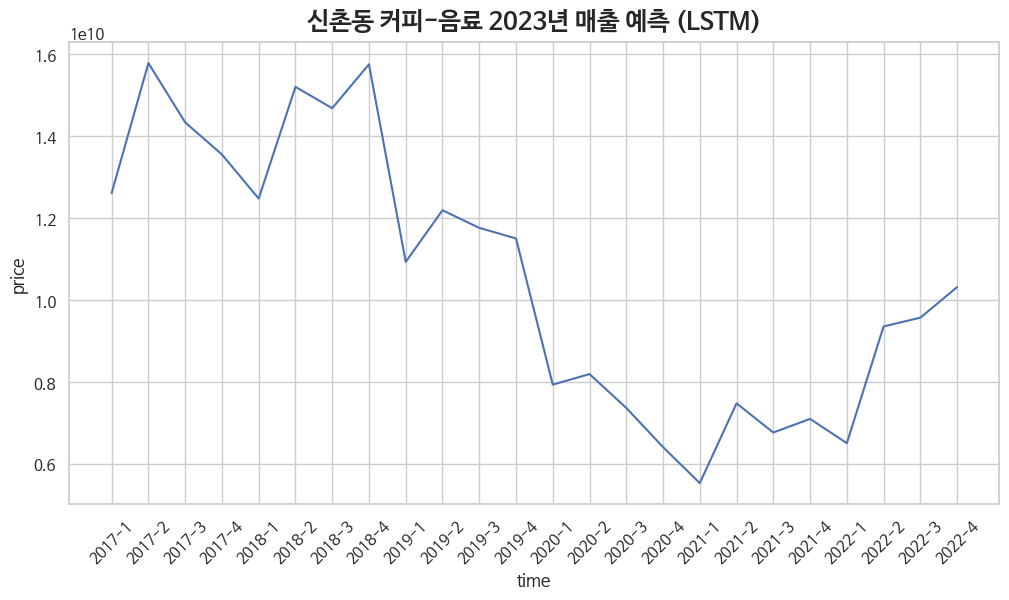

In [15]:
### seaborn lineplot을 이용, 전체 매출 시각화

# 시각화에 필요한 matplotlib.pyplot, seaborn 라이브러리 임폴트
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화

sns.set(style="whitegrid", color_codes=True, font='NanumBarunGothic')

plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['분기당_매출_금액'])
plt.title('신촌동 커피-음료 2023년 매출 예측 (LSTM)', fontsize = 18, fontweight='bold', pad =10)
plt.xlabel('time')
plt.xticks(rotation=45)
plt.ylabel('price')
plt.show()

## 23년 1분기 매출 예측

In [16]:
### X / y 데이터 생성
X = sin_coffee[['성장성', '시장성', '순점포증감률']]
y = sin_coffee.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  9.582203e+06  0.421941
1   1.251778  1.317550e+07 -3.043478
2   0.908274  9.532443e+06 -1.769912
3   0.945307  1.378365e+07 -6.603774
4   0.920410  1.377974e+07 -4.433498
5   1.218829  1.496086e+07  5.581395
6   0.965745  1.508716e+07  2.714932
7   1.072989  1.770817e+07 -0.913242
8   0.693516  1.147899e+07 -0.458716
9   1.115654  1.275232e+07  6.837607
10  0.964671  1.154829e+07  1.271186
11  0.977961  1.107477e+07  4.435484
12  0.689492  5.408660e+06 -0.796813
13  1.032439  5.052693e+06  0.000000
14  0.898980  3.661522e+06  0.398406
15  0.870035  1.053397e+06  1.181102
16  0.862439 -1.355902e+05 -0.395257
17  1.353052 -6.061034e+05  3.435115
18  0.904464 -3.937207e+05 -0.769231
19  1.049390 -4.183269e+05  0.383142
20  0.916232 -2.705196e+05  1.879699
21  1.439035  1.270680e+06  2.554745
22  1.022862  3.915651e+06  3.859649
23  1.078135  6.549422e+06 -0.354610
---------------------------------------------------------------------------

In [17]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [18]:
### 시계열 분석에 적합한 데이터를 만들어 주는 함수 정의
def make_dataset(X, y, window_size=10):
    X_data = []
    y_data = []
    for start in np.arange(len(X) - window_size):
        stop = start + window_size
        X_data.append(X[start:stop, :])
        y_data.append(y[stop])
    return np.array(X_data), np.array(y_data)




### 시계열 분석에서 마지막 테스트 데이터를 만들어 주는 함수 정의
def make_last_dataset(X, window_size=10):
    X_data_last = []
    for start in np.arange(len(X) - window_size +1):
        stop = start + window_size
        X_data_last.append(X[start:stop, :])
    return X_data_last[-1]

In [19]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [20]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.44476465 0.24689783 0.77844852]
 [0.51850676 0.39070751 0.46491978]]


In [21]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [22]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
# model.compile(loss='mean_squared_error', optimizer='adam')

model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 64)             17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [23]:
### 모델 학습

# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6482
Epoch 1: val_loss improved from inf to 0.03269, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.6482 - val_loss: 0.0327
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6277
Epoch 2: val_loss improved from 0.03269 to 0.02940, saving model to stock_model.h5
1/1 [==============================] - 0s 134ms/step - loss: 0.6277 - val_loss: 0.0294
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.6080
Epoch 3: val_loss improved from 0.02940 to 0.02637, saving model to stock_model.h5
1/1 [==============================] - 0s 143ms/step - loss: 0.6080 - val_loss: 0.0264
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5889
Epoch 4: val_loss improved from 0.02637 to 0.02358, saving model to stock_model.h5
1/1 [==============================] - 0s 143ms/step - loss: 0.5889 - val_loss: 0.0236
Epoch 5/100
1/1 [==============

In [24]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 893ms/step
[[0.14060257]
 [0.15028432]
 [0.16394354]
 [0.18672028]]


In [25]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.095053,0.140603
2022-2,0.373020,0.150284
2022-3,0.393850,0.163944
2022-4,0.466666,0.186720


In [26]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_coffee의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.095053,0.140603,6499152739,6.966726e+09,-4.675729e+08
2022-2,0.373020,0.150284,9352509875,7.066110e+09,2.286400e+09
2022-3,0.393850,0.163944,9566330395,7.206323e+09,2.360007e+09
2022-4,0.466666,0.186720,10313798137,7.440129e+09,2.873670e+09


### 결과

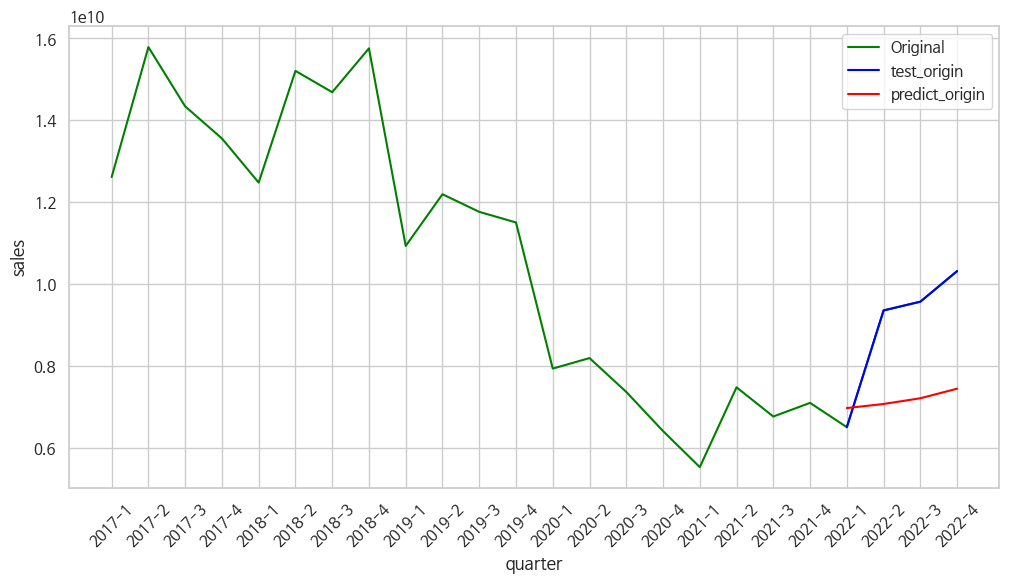

In [27]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [28]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     1.763126e+09
std      1.509901e+09
min     -4.675729e+08
25%      1.597907e+09
50%      2.323204e+09
75%      2.488423e+09
max      2.873670e+09
dtype: float64

In [29]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 35ms/step
[[0.17698611]]
--------------------------------------------------------------------------------
예측된 매출  : 7340206592.0 


## 23년 1분기 성장성 예측

In [30]:
# 성장을 예측하기 위한 지표로는 성장성, 안정성, 시장성, 순점포증감률 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_coffee[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_coffee.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

      분기당_매출_금액           시장성    순점포증감률
0   12612878611  9.582203e+06  0.421941
1   15788523147  1.317550e+07 -3.043478
2   14340299471  9.532443e+06 -1.769912
3   13555990768  1.378365e+07 -6.603774
4   12477063574  1.377974e+07 -4.433498
5   15207408519  1.496086e+07  5.581395
6   14686483805  1.508716e+07  2.714932
7   15758428260  1.770817e+07 -0.913242
8   10928721210  1.147899e+07 -0.458716
9   12192669082  1.275232e+07  6.837607
10  11761916413  1.154829e+07  1.271186
11  11502695158  1.107477e+07  4.435484
12   7931016841  5.408660e+06 -0.796813
13   8188290313  5.052693e+06  0.000000
14   7361111652  3.661522e+06  0.398406
15   6404426431  1.053397e+06  1.181102
16   5523426664 -1.355902e+05 -0.395257
17   7473482844 -6.061034e+05  3.435115
18   6759493748 -3.937207e+05 -0.769231
19   7093346336 -4.183269e+05  0.383142
20   6499152739 -2.705196e+05  1.879699
21   9352509875  1.270680e+06  2.554745
22   9566330395  3.915651e+06  3.859649
23  10313798137  6.549422e+06 -0.354610


In [31]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [32]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [33]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.39384956 0.24689783 0.77844852]
 [0.466666   0.39070751 0.46491978]]


In [34]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [35]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [36]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2120
Epoch 1: val_loss improved from inf to 0.19017, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.2120 - val_loss: 0.1902
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2000
Epoch 2: val_loss improved from 0.19017 to 0.18344, saving model to stock_model.h5
1/1 [==============================] - 0s 93ms/step - loss: 0.2000 - val_loss: 0.1834
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.1886
Epoch 3: val_loss improved from 0.18344 to 0.17701, saving model to stock_model.h5
1/1 [==============================] - 0s 110ms/step - loss: 0.1886 - val_loss: 0.1770
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1777
Epoch 4: val_loss improved from 0.17701 to 0.17086, saving model to stock_model.h5
1/1 [==============================] - 0s 95ms/step - loss: 0.1777 - val_loss: 0.1709
Epoch 5/100
1/1 [================

In [37]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 809ms/step
[[0.24864776]
 [0.2619884 ]
 [0.28637955]
 [0.3371069 ]]


In [38]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.302505,0.248648
2022-2,1.000000,0.261988
2022-3,0.444765,0.286380
2022-4,0.518507,0.337107


In [39]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 3].values       # 성장성이 sin_coffee의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.302505,0.248648,0.916232,0.875864,0.040368
2022-2,1.000000,0.261988,1.439035,0.885864,0.553172
2022-3,0.444765,0.286380,1.022862,0.904146,0.118716
2022-4,0.518507,0.337107,1.078135,0.942168,0.135967


### 결과

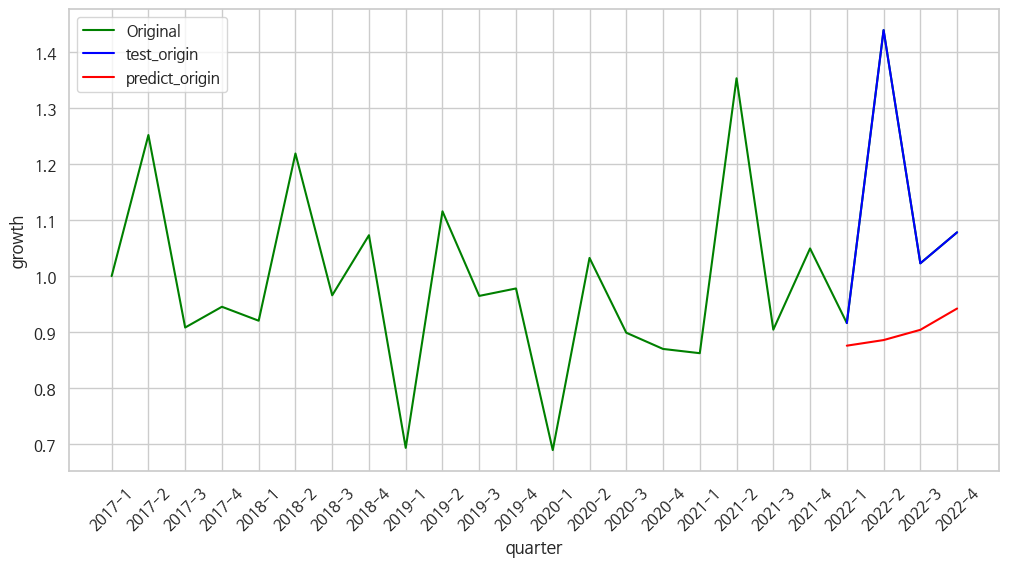

In [40]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [41]:
## error의 요약 통계량
error.describe()

count    4.000000
mean     0.212056
std      0.231184
min      0.040368
25%      0.099129
50%      0.127342
75%      0.240268
max      0.553172
dtype: float64

In [42]:
### 23년 1분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 33ms/step
[[0.35346287]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.9544277191162109 


## 23년 1분기 시장성 예측

In [43]:
# 시장성을 예측하기 위한 지표로는 성장성, 안정성, 총매출, 순점포증감률 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_coffee[['성장성', '분기당_매출_금액', '순점포증감률']]
y = sin_coffee.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성    분기당_매출_금액    순점포증감률
0   1.000000  12612878611  0.421941
1   1.251778  15788523147 -3.043478
2   0.908274  14340299471 -1.769912
3   0.945307  13555990768 -6.603774
4   0.920410  12477063574 -4.433498
5   1.218829  15207408519  5.581395
6   0.965745  14686483805  2.714932
7   1.072989  15758428260 -0.913242
8   0.693516  10928721210 -0.458716
9   1.115654  12192669082  6.837607
10  0.964671  11761916413  1.271186
11  0.977961  11502695158  4.435484
12  0.689492   7931016841 -0.796813
13  1.032439   8188290313  0.000000
14  0.898980   7361111652  0.398406
15  0.870035   6404426431  1.181102
16  0.862439   5523426664 -0.395257
17  1.353052   7473482844  3.435115
18  0.904464   6759493748 -0.769231
19  1.049390   7093346336  0.383142
20  0.916232   6499152739  1.879699
21  1.439035   9352509875  2.554745
22  1.022862   9566330395  3.859649
23  1.078135  10313798137 -0.354610
--------------------------------------------------------------------------------
             시장성
0 

In [44]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [45]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [46]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.44476465 0.39384956 0.77844852]
 [0.51850676 0.466666   0.46491978]]


In [47]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [48]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [49]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6425
Epoch 1: val_loss improved from inf to 0.03682, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.6425 - val_loss: 0.0368
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6215
Epoch 2: val_loss improved from 0.03682 to 0.03399, saving model to stock_model.h5
1/1 [==============================] - 0s 114ms/step - loss: 0.6215 - val_loss: 0.0340
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.6012
Epoch 3: val_loss improved from 0.03399 to 0.03140, saving model to stock_model.h5
1/1 [==============================] - 0s 120ms/step - loss: 0.6012 - val_loss: 0.0314
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5816
Epoch 4: val_loss improved from 0.03140 to 0.02904, saving model to stock_model.h5
1/1 [==============================] - 0s 137ms/step - loss: 0.5816 - val_loss: 0.0290
Epoch 5/100
1/1 [==============

In [50]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 832ms/step
[[0.1238421 ]
 [0.13161969]
 [0.14347138]
 [0.16585402]]


In [51]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.018324,0.123842
2022-2,0.102477,0.131620
2022-3,0.246898,0.143471
2022-4,0.390708,0.165854


In [52]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 5].values       # 시장성이 sin_coffee의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.018324,0.123842,-2.705196e+05,1661974.875,-1.932495e+06
2022-2,0.102477,0.131620,1.270680e+06,1804415.875,-5.337359e+05
2022-3,0.246898,0.143471,3.915651e+06,2021470.875,1.894181e+06
2022-4,0.390708,0.165854,6.549422e+06,2431392.750,4.118029e+06


### 결과

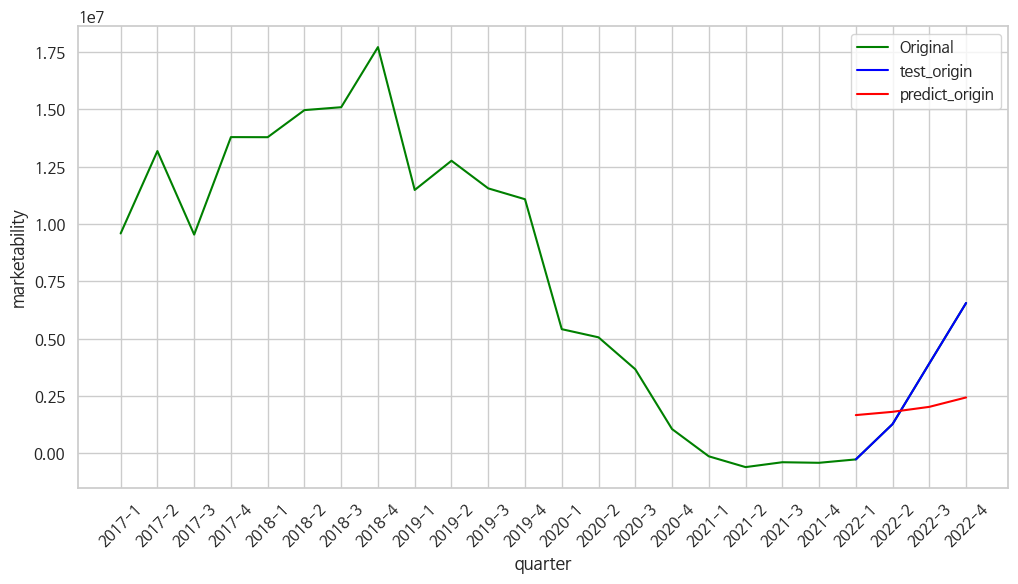

In [53]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [54]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     8.864947e+05
std      2.672202e+06
min     -1.932495e+06
25%     -8.834255e+05
50%      6.802223e+05
75%      2.450143e+06
max      4.118029e+06
dtype: float64

In [55]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 26ms/step
[[0.15332778]]
--------------------------------------------------------------------------------
예측된 시장성  : 2201983.75 


## 23년 1분기 순점포증감률 예측

In [56]:
# 순점포증감률을 예측하기 위한 지표로는 성장성, 안정성, 총매출, 시장성 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_coffee[['성장성', '분기당_매출_금액', '시장성']]
y = sin_coffee.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성    분기당_매출_금액           시장성
0   1.000000  12612878611  9.582203e+06
1   1.251778  15788523147  1.317550e+07
2   0.908274  14340299471  9.532443e+06
3   0.945307  13555990768  1.378365e+07
4   0.920410  12477063574  1.377974e+07
5   1.218829  15207408519  1.496086e+07
6   0.965745  14686483805  1.508716e+07
7   1.072989  15758428260  1.770817e+07
8   0.693516  10928721210  1.147899e+07
9   1.115654  12192669082  1.275232e+07
10  0.964671  11761916413  1.154829e+07
11  0.977961  11502695158  1.107477e+07
12  0.689492   7931016841  5.408660e+06
13  1.032439   8188290313  5.052693e+06
14  0.898980   7361111652  3.661522e+06
15  0.870035   6404426431  1.053397e+06
16  0.862439   5523426664 -1.355902e+05
17  1.353052   7473482844 -6.061034e+05
18  0.904464   6759493748 -3.937207e+05
19  1.049390   7093346336 -4.183269e+05
20  0.916232   6499152739 -2.705196e+05
21  1.439035   9352509875  1.270680e+06
22  1.022862   9566330395  3.915651e+06
23  1.078135  10313798137  6.549422e+06


In [57]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [58]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [59]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.44476465 0.39384956 0.24689783]
 [0.51850676 0.466666   0.39070751]]


In [60]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [61]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [62]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4316
Epoch 1: val_loss improved from inf to 0.28926, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.4316 - val_loss: 0.2893
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.4149
Epoch 2: val_loss improved from 0.28926 to 0.28035, saving model to stock_model.h5
1/1 [==============================] - 0s 97ms/step - loss: 0.4149 - val_loss: 0.2804
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3988
Epoch 3: val_loss improved from 0.28035 to 0.27171, saving model to stock_model.h5
1/1 [==============================] - 0s 94ms/step - loss: 0.3988 - val_loss: 0.2717
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3833
Epoch 4: val_loss improved from 0.27171 to 0.26327, saving model to stock_model.h5
1/1 [==============================] - 0s 91ms/step - loss: 0.3833 - val_loss: 0.2633
Epoch 5/100
1/1 [=================

In [63]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.2837977 ]
 [0.29277417]
 [0.32299265]
 [0.41901207]]


In [64]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.631146,0.283798
2022-2,0.681367,0.292774
2022-3,0.778449,0.322993
2022-4,0.464920,0.419012


In [65]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_coffee의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.631146,0.283798,1.879699,-2.789141,4.668840
2022-2,0.681367,0.292774,2.554745,-2.668485,5.223229
2022-3,0.778449,0.322993,3.859649,-2.262306,6.121956
2022-4,0.464920,0.419012,-0.354610,-0.971673,0.617063


### 결과

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


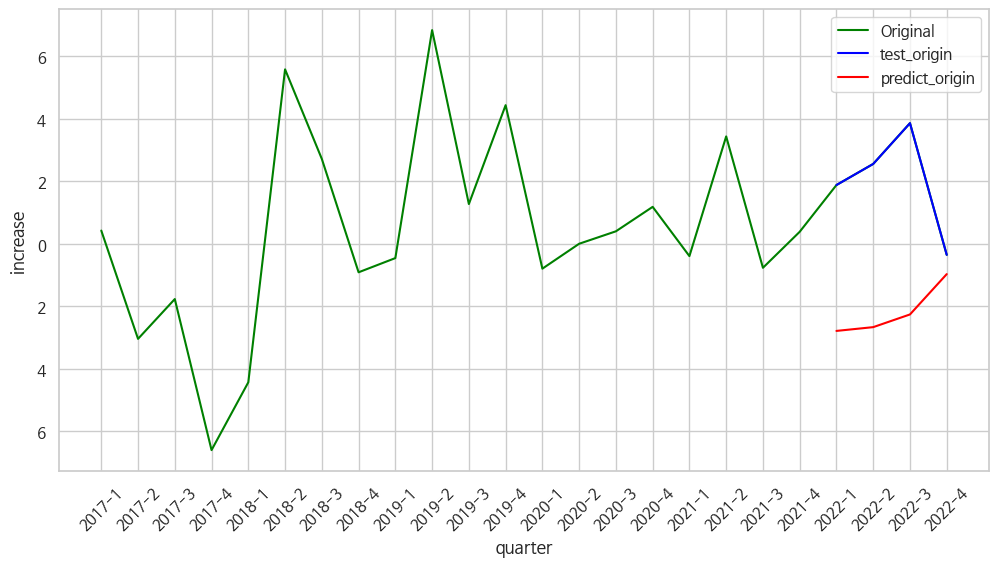

In [66]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [67]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     4.157772
std      2.435229
min      0.617063
25%      3.655896
50%      4.946035
75%      5.447911
max      6.121956
dtype: float64

In [68]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 29ms/step
[[0.42854887]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -0.8434851169586182 


## 원본 데이터에 예측값 추가하기

In [69]:
print(sales)
print(growth)
print(marketability)
print(increase)

7340206600.0
0.9544277
2201983.8
-0.8434851


In [70]:
sin_coffee.loc[24] = ['2023-1', '커피-음료', sales, growth, increase, marketability]

<ipython-input-70-f40e8aae4072>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_coffee.loc[24] = ['2023-1', '커피-음료', sales, growth, increase, marketability]


In [71]:
sin_coffee

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,커피-음료,1.261288e+10,1.000000,0.421941,9.582203e+06
1,2017-2,커피-음료,1.578852e+10,1.251778,-3.043478,1.317550e+07
2,2017-3,커피-음료,1.434030e+10,0.908274,-1.769912,9.532443e+06
3,2017-4,커피-음료,1.355599e+10,0.945307,-6.603774,1.378365e+07
4,2018-1,커피-음료,1.247706e+10,0.920410,-4.433498,1.377974e+07
5,2018-2,커피-음료,1.520741e+10,1.218829,5.581395,1.496086e+07
6,2018-3,커피-음료,1.468648e+10,0.965745,2.714932,1.508716e+07
7,2018-4,커피-음료,1.575843e+10,1.072989,-0.913242,1.770817e+07
8,2019-1,커피-음료,1.092872e+10,0.693516,-0.458716,1.147899e+07
9,2019-2,커피-음료,1.219267e+10,1.115654,6.837607,1.275232e+07


## 23년 2분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본 데이터에 추가

### 매출

In [72]:
################ 매출 ####################

# 총 매출액을 예측하기 위한 지표로는 성장성, 시장성, 순점포증감률 선정.

### X / y 데이터 생성
X = sin_coffee[['성장성', '시장성', '순점포증감률']]
y = sin_coffee.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  9.582203e+06  0.421941
1   1.251778  1.317550e+07 -3.043478
2   0.908274  9.532443e+06 -1.769912
3   0.945307  1.378365e+07 -6.603774
4   0.920410  1.377974e+07 -4.433498
5   1.218829  1.496086e+07  5.581395
6   0.965745  1.508716e+07  2.714932
7   1.072989  1.770817e+07 -0.913242
8   0.693516  1.147899e+07 -0.458716
9   1.115654  1.275232e+07  6.837607
10  0.964671  1.154829e+07  1.271186
11  0.977961  1.107477e+07  4.435484
12  0.689492  5.408660e+06 -0.796813
13  1.032439  5.052693e+06  0.000000
14  0.898980  3.661522e+06  0.398406
15  0.870035  1.053397e+06  1.181102
16  0.862439 -1.355902e+05 -0.395257
17  1.353052 -6.061034e+05  3.435115
18  0.904464 -3.937207e+05 -0.769231
19  1.049390 -4.183269e+05  0.383142
20  0.916232 -2.705196e+05  1.879699
21  1.439035  1.270680e+06  2.554745
22  1.022862  3.915651e+06  3.859649
23  1.078135  6.549422e+06 -0.354610
24  0.954428  2.201984e+06 -0.843485
--------------------------------------

In [73]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [74]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.51850676 0.39070751 0.46491978]
 [0.35346284 0.15332778 0.42854888]]


In [75]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [76]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [77]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.5959
Epoch 1: val_loss improved from inf to 0.02560, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.5959 - val_loss: 0.0256
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.5766
Epoch 2: val_loss improved from 0.02560 to 0.02292, saving model to stock_model.h5
1/1 [==============================] - 0s 97ms/step - loss: 0.5766 - val_loss: 0.0229
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5581
Epoch 3: val_loss improved from 0.02292 to 0.02047, saving model to stock_model.h5
1/1 [==============================] - 0s 101ms/step - loss: 0.5581 - val_loss: 0.0205
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5402
Epoch 4: val_loss improved from 0.02047 to 0.01823, saving model to stock_model.h5
1/1 [==============================] - 0s 113ms/step - loss: 0.5402 - val_loss: 0.0182
Epoch 5/100
1/1 [===============

In [78]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 873ms/step
[[0.13893884]
 [0.15133545]
 [0.1718776 ]
 [0.16259953]]


In [79]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.373020,0.138939
2022-3,0.393850,0.151335
2022-4,0.466666,0.171878
2023-1,0.176986,0.162600


In [80]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_coffee의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.373020,0.138939,9.352510e+09,6.949647e+09,2.402863e+09
2022-3,0.393850,0.151335,9.566330e+09,7.076900e+09,2.489431e+09
2022-4,0.466666,0.171878,1.031380e+10,7.287767e+09,3.026032e+09
2023-1,0.176986,0.162600,7.340207e+09,7.192526e+09,1.476803e+08


In [81]:
df_test = df_test.reset_index()

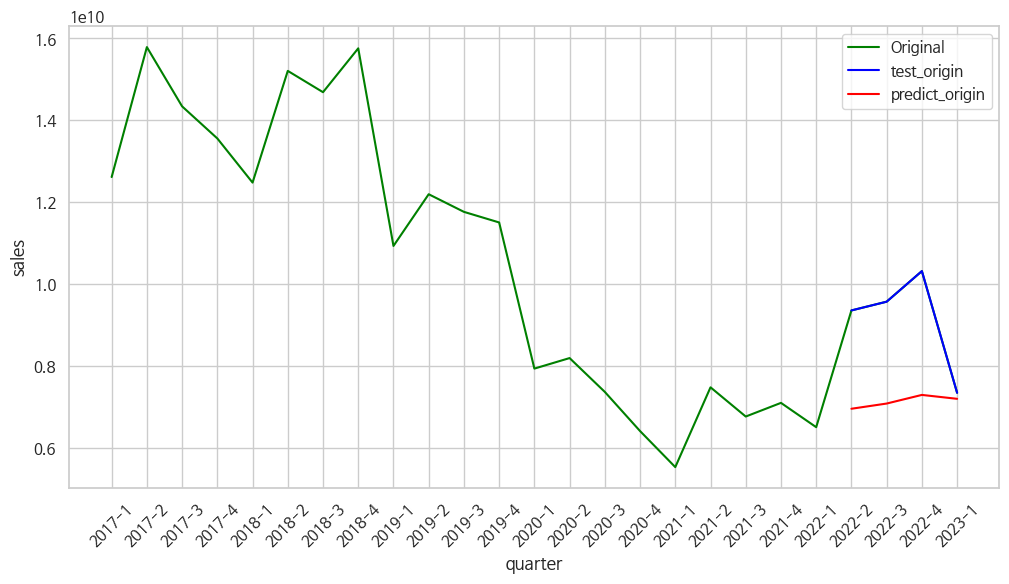

In [82]:
### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [83]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     2.016501e+09
std      1.276007e+09
min      1.476803e+08
25%      1.839067e+09
50%      2.446147e+09
75%      2.623581e+09
max      3.026032e+09
dtype: float64

In [84]:
### 23년 2분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 25ms/step
[[0.14931253]]
--------------------------------------------------------------------------------
예측된 매출  : 7056134144.0 


### 성장성

In [85]:
### X / y 데이터 생성
X = sin_coffee[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_coffee.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   1.261288e+10  9.582203e+06  0.421941
1   1.578852e+10  1.317550e+07 -3.043478
2   1.434030e+10  9.532443e+06 -1.769912
3   1.355599e+10  1.378365e+07 -6.603774
4   1.247706e+10  1.377974e+07 -4.433498
5   1.520741e+10  1.496086e+07  5.581395
6   1.468648e+10  1.508716e+07  2.714932
7   1.575843e+10  1.770817e+07 -0.913242
8   1.092872e+10  1.147899e+07 -0.458716
9   1.219267e+10  1.275232e+07  6.837607
10  1.176192e+10  1.154829e+07  1.271186
11  1.150270e+10  1.107477e+07  4.435484
12  7.931017e+09  5.408660e+06 -0.796813
13  8.188290e+09  5.052693e+06  0.000000
14  7.361112e+09  3.661522e+06  0.398406
15  6.404426e+09  1.053397e+06  1.181102
16  5.523427e+09 -1.355902e+05 -0.395257
17  7.473483e+09 -6.061034e+05  3.435115
18  6.759494e+09 -3.937207e+05 -0.769231
19  7.093346e+09 -4.183269e+05  0.383142
20  6.499153e+09 -2.705196e+05  1.879699
21  9.352510e+09  1.270680e+06  2.554745
22  9.566330e+09  3.915651e+06  3.859649
23  1.031380e+10

In [86]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [87]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.466666   0.39070751 0.46491978]
 [0.17698615 0.15332778 0.42854888]]


In [88]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [89]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [90]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.1929
Epoch 1: val_loss improved from inf to 0.20140, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.1929 - val_loss: 0.2014
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.1819
Epoch 2: val_loss improved from 0.20140 to 0.19414, saving model to stock_model.h5
1/1 [==============================] - 0s 117ms/step - loss: 0.1819 - val_loss: 0.1941
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.1714
Epoch 3: val_loss improved from 0.19414 to 0.18716, saving model to stock_model.h5
1/1 [==============================] - 0s 97ms/step - loss: 0.1714 - val_loss: 0.1872
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1616
Epoch 4: val_loss improved from 0.18716 to 0.18043, saving model to stock_model.h5
1/1 [==============================] - 0s 119ms/step - loss: 0.1616 - val_loss: 0.1804
Epoch 5/100
1/1 [===============

In [91]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 811ms/step
[[0.24040322]
 [0.26228732]
 [0.30872536]
 [0.32393798]]


In [92]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,1.000000,0.240403
2022-3,0.444765,0.262287
2022-4,0.518507,0.308725
2023-1,0.353463,0.323938


In [93]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 3].values       # 성장성이 sin_coffee의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,1.000000,0.240403,1.439035,0.869685,0.569351
2022-3,0.444765,0.262287,1.022862,0.886088,0.136775
2022-4,0.518507,0.308725,1.078135,0.920895,0.157240
2023-1,0.353463,0.323938,0.954428,0.932298,0.022130


In [94]:
df_test = df_test.reset_index()

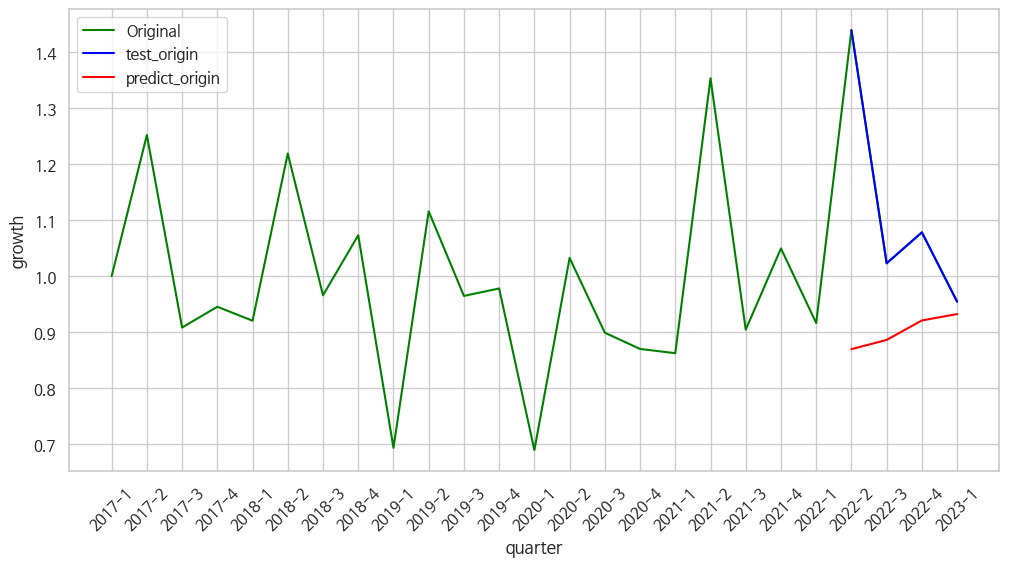

In [95]:
### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [96]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.221374
std      0.239483
min      0.022130
25%      0.108114
50%      0.147007
75%      0.260268
max      0.569351
dtype: float64

In [97]:
### 23년 2분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 25ms/step
[[0.29319653]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.9092555642127991 


### 시장성

In [98]:
### X / y 데이터 생성
X = sin_coffee[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_coffee.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   1.261288e+10  1.000000  0.421941
1   1.578852e+10  1.251778 -3.043478
2   1.434030e+10  0.908274 -1.769912
3   1.355599e+10  0.945307 -6.603774
4   1.247706e+10  0.920410 -4.433498
5   1.520741e+10  1.218829  5.581395
6   1.468648e+10  0.965745  2.714932
7   1.575843e+10  1.072989 -0.913242
8   1.092872e+10  0.693516 -0.458716
9   1.219267e+10  1.115654  6.837607
10  1.176192e+10  0.964671  1.271186
11  1.150270e+10  0.977961  4.435484
12  7.931017e+09  0.689492 -0.796813
13  8.188290e+09  1.032439  0.000000
14  7.361112e+09  0.898980  0.398406
15  6.404426e+09  0.870035  1.181102
16  5.523427e+09  0.862439 -0.395257
17  7.473483e+09  1.353052  3.435115
18  6.759494e+09  0.904464 -0.769231
19  7.093346e+09  1.049390  0.383142
20  6.499153e+09  0.916232  1.879699
21  9.352510e+09  1.439035  2.554745
22  9.566330e+09  1.022862  3.859649
23  1.031380e+10  1.078135 -0.354610
24  7.340207e+09  0.954428 -0.843485
--------------------------------------

In [99]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [100]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.466666   0.51850676 0.46491978]
 [0.17698615 0.35346284 0.42854888]]


In [101]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [102]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [103]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.5780
Epoch 1: val_loss improved from inf to 0.02144, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.5780 - val_loss: 0.0214
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.5586
Epoch 2: val_loss improved from 0.02144 to 0.01956, saving model to stock_model.h5
1/1 [==============================] - 0s 159ms/step - loss: 0.5586 - val_loss: 0.0196
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5400
Epoch 3: val_loss improved from 0.01956 to 0.01789, saving model to stock_model.h5
1/1 [==============================] - 0s 147ms/step - loss: 0.5400 - val_loss: 0.0179
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5218
Epoch 4: val_loss improved from 0.01789 to 0.01640, saving model to stock_model.h5
1/1 [==============================] - 0s 141ms/step - loss: 0.5218 - val_loss: 0.0164
Epoch 5/100
1/1 [==============

In [104]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 839ms/step
[[0.0908647 ]
 [0.09654991]
 [0.1118379 ]
 [0.11230686]]


In [105]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.102477,0.090865
2022-3,0.246898,0.096550
2022-4,0.390708,0.111838
2023-1,0.153328,0.112307


In [106]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 5].values       # 시장성이 sin_coffee의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.102477,0.090865,1.270680e+06,1058017.750,2.126623e+05
2022-3,0.246898,0.096550,3.915651e+06,1162138.375,2.753513e+06
2022-4,0.390708,0.111838,6.549422e+06,1442126.750,5.107295e+06
2023-1,0.153328,0.112307,2.201984e+06,1450715.375,7.512684e+05


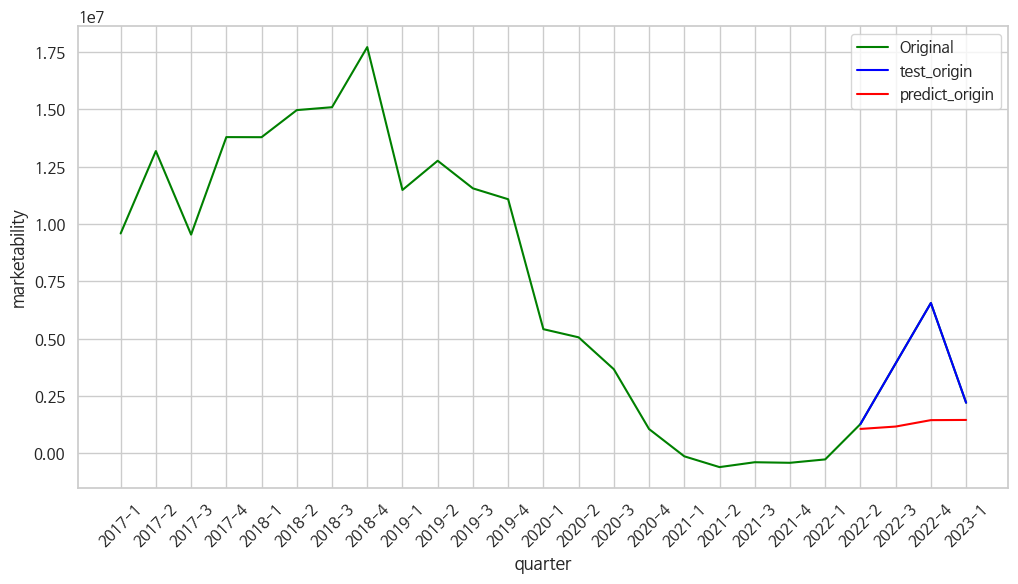

In [107]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [108]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     2.206185e+06
std      2.221630e+06
min      2.126623e+05
25%      6.166168e+05
50%      1.752391e+06
75%      3.341958e+06
max      5.107295e+06
dtype: float64

In [109]:
### 23년 2분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 38ms/step
[[0.10097134]]
--------------------------------------------------------------------------------
예측된 시장성  : 1243113.625 


### 순점포증감률

In [110]:
### X / y 데이터 생성
X = sin_coffee[['분기당_매출_금액', '성장성', '시장성']]
y = sin_coffee.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   1.261288e+10  1.000000  9.582203e+06
1   1.578852e+10  1.251778  1.317550e+07
2   1.434030e+10  0.908274  9.532443e+06
3   1.355599e+10  0.945307  1.378365e+07
4   1.247706e+10  0.920410  1.377974e+07
5   1.520741e+10  1.218829  1.496086e+07
6   1.468648e+10  0.965745  1.508716e+07
7   1.575843e+10  1.072989  1.770817e+07
8   1.092872e+10  0.693516  1.147899e+07
9   1.219267e+10  1.115654  1.275232e+07
10  1.176192e+10  0.964671  1.154829e+07
11  1.150270e+10  0.977961  1.107477e+07
12  7.931017e+09  0.689492  5.408660e+06
13  8.188290e+09  1.032439  5.052693e+06
14  7.361112e+09  0.898980  3.661522e+06
15  6.404426e+09  0.870035  1.053397e+06
16  5.523427e+09  0.862439 -1.355902e+05
17  7.473483e+09  1.353052 -6.061034e+05
18  6.759494e+09  0.904464 -3.937207e+05
19  7.093346e+09  1.049390 -4.183269e+05
20  6.499153e+09  0.916232 -2.705196e+05
21  9.352510e+09  1.439035  1.270680e+06
22  9.566330e+09  1.022862  3.915651e+06
23  1.031380e+10

In [111]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [112]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.466666   0.51850676 0.39070751]
 [0.17698615 0.35346284 0.15332778]]


In [113]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [114]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [115]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3991
Epoch 1: val_loss improved from inf to 0.31972, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.3991 - val_loss: 0.3197
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3834
Epoch 2: val_loss improved from 0.31972 to 0.31082, saving model to stock_model.h5
1/1 [==============================] - 0s 113ms/step - loss: 0.3834 - val_loss: 0.3108
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3682
Epoch 3: val_loss improved from 0.31082 to 0.30211, saving model to stock_model.h5
1/1 [==============================] - 0s 129ms/step - loss: 0.3682 - val_loss: 0.3021
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3535
Epoch 4: val_loss improved from 0.30211 to 0.29355, saving model to stock_model.h5
1/1 [==============================] - 0s 121ms/step - loss: 0.3535 - val_loss: 0.2936
Epoch 5/100
1/1 [==============

In [116]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 821ms/step
[[0.27752608]
 [0.30594158]
 [0.39837745]
 [0.4180261 ]]


In [117]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.681367,0.277526
2022-3,0.778449,0.305942
2022-4,0.464920,0.398377
2023-1,0.428549,0.418026


In [118]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_coffee의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.681367,0.277526,2.554745,-2.873440,5.428185
2022-3,0.778449,0.305942,3.859649,-2.491497,6.351146
2022-4,0.464920,0.398377,-0.354610,-1.249031,0.894421
2023-1,0.428549,0.418026,-0.843485,-0.984926,0.141441


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


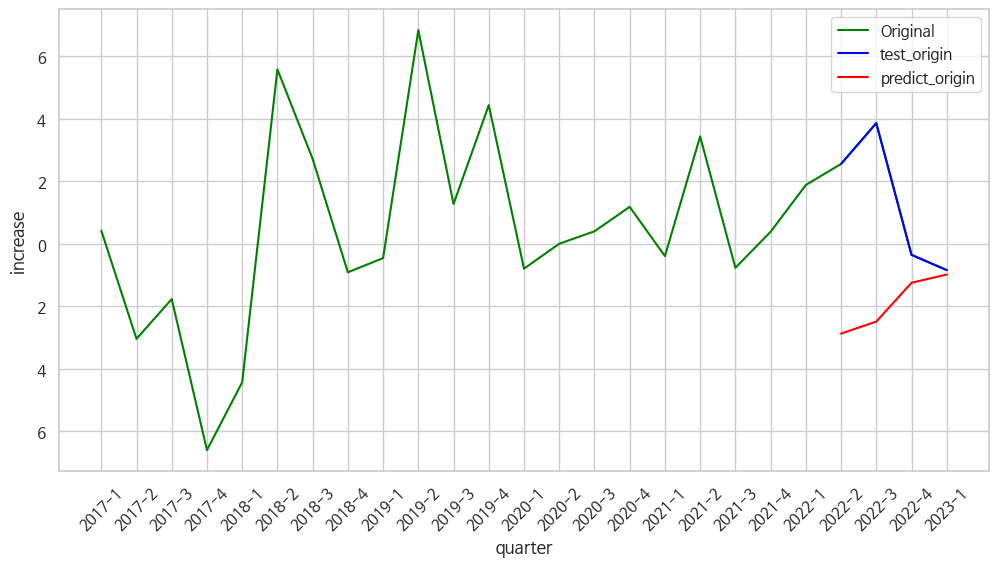

In [119]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [120]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     3.203798
std      3.139265
min      0.141441
25%      0.706176
50%      3.161303
75%      5.658925
max      6.351146
dtype: float64

In [121]:
### 23년 2분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 27ms/step
[[0.4124339]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -1.0600926876068115 


### 추가


In [122]:
sin_coffee.loc[25] = ['2023-2', '커피-음료', sales, growth, increase, marketability]

<ipython-input-122-96bb56435779>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_coffee.loc[25] = ['2023-2', '커피-음료', sales, growth, increase, marketability]


In [123]:
sin_coffee

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,커피-음료,1.261288e+10,1.000000,0.421941,9.582203e+06
1,2017-2,커피-음료,1.578852e+10,1.251778,-3.043478,1.317550e+07
2,2017-3,커피-음료,1.434030e+10,0.908274,-1.769912,9.532443e+06
3,2017-4,커피-음료,1.355599e+10,0.945307,-6.603774,1.378365e+07
4,2018-1,커피-음료,1.247706e+10,0.920410,-4.433498,1.377974e+07
5,2018-2,커피-음료,1.520741e+10,1.218829,5.581395,1.496086e+07
6,2018-3,커피-음료,1.468648e+10,0.965745,2.714932,1.508716e+07
7,2018-4,커피-음료,1.575843e+10,1.072989,-0.913242,1.770817e+07
8,2019-1,커피-음료,1.092872e+10,0.693516,-0.458716,1.147899e+07
9,2019-2,커피-음료,1.219267e+10,1.115654,6.837607,1.275232e+07


## 23년 3분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본 데이터에 추가

### 매출

In [124]:
################ 매출 ####################

### X / y 데이터 생성
X = sin_coffee[['성장성', '시장성', '순점포증감률']]
y = sin_coffee.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  9.582203e+06  0.421941
1   1.251778  1.317550e+07 -3.043478
2   0.908274  9.532443e+06 -1.769912
3   0.945307  1.378365e+07 -6.603774
4   0.920410  1.377974e+07 -4.433498
5   1.218829  1.496086e+07  5.581395
6   0.965745  1.508716e+07  2.714932
7   1.072989  1.770817e+07 -0.913242
8   0.693516  1.147899e+07 -0.458716
9   1.115654  1.275232e+07  6.837607
10  0.964671  1.154829e+07  1.271186
11  0.977961  1.107477e+07  4.435484
12  0.689492  5.408660e+06 -0.796813
13  1.032439  5.052693e+06  0.000000
14  0.898980  3.661522e+06  0.398406
15  0.870035  1.053397e+06  1.181102
16  0.862439 -1.355902e+05 -0.395257
17  1.353052 -6.061034e+05  3.435115
18  0.904464 -3.937207e+05 -0.769231
19  1.049390 -4.183269e+05  0.383142
20  0.916232 -2.705196e+05  1.879699
21  1.439035  1.270680e+06  2.554745
22  1.022862  3.915651e+06  3.859649
23  1.078135  6.549422e+06 -0.354610
24  0.954428  2.201984e+06 -0.843485
25  0.909256  1.243114e+06 -1.060093
-

In [125]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [126]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.35346284 0.15332778 0.42854888]
 [0.2931966  0.10097134 0.4124339 ]]


In [127]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [128]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [129]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.5532
Epoch 1: val_loss improved from inf to 0.03344, saving model to stock_model.h5
1/1 [==============================] - 7s 7s/step - loss: 0.5532 - val_loss: 0.0334
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.5349
Epoch 2: val_loss improved from 0.03344 to 0.03073, saving model to stock_model.h5
1/1 [==============================] - 0s 114ms/step - loss: 0.5349 - val_loss: 0.0307
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5174
Epoch 3: val_loss improved from 0.03073 to 0.02825, saving model to stock_model.h5
1/1 [==============================] - 0s 94ms/step - loss: 0.5174 - val_loss: 0.0282
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5005
Epoch 4: val_loss improved from 0.02825 to 0.02595, saving model to stock_model.h5
1/1 [==============================] - 0s 93ms/step - loss: 0.5005 - val_loss: 0.0259
Epoch 5/100
1/1 [================

In [130]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 2s 2s/step
[[0.16411561]
 [0.18679687]
 [0.17698345]
 [0.16228248]]


In [131]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.393850,0.164116
2022-4,0.466666,0.186797
2023-1,0.176986,0.176983
2023-2,0.149313,0.162282


In [132]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_coffee의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.393850,0.164116,9.566330e+09,7.208089e+09,2.358241e+09
2022-4,0.466666,0.186797,1.031380e+10,7.440914e+09,2.872884e+09
2023-1,0.176986,0.176983,7.340207e+09,7.340179e+09,2.764800e+04
2023-2,0.149313,0.162282,7.056134e+09,7.189272e+09,-1.331379e+08


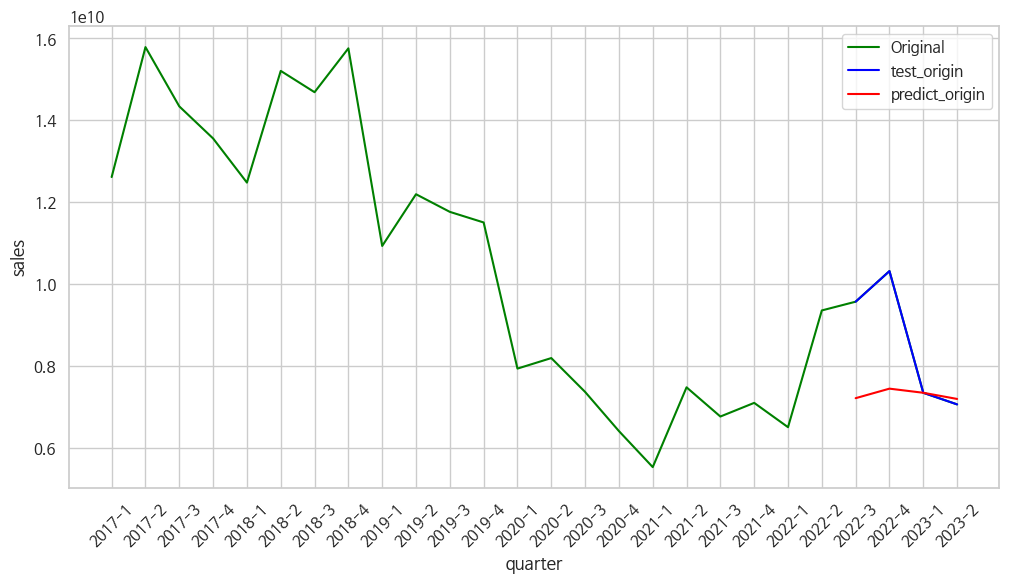

In [133]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [134]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     1.274504e+09
std      1.563655e+09
min     -1.331379e+08
25%     -3.326374e+07
50%      1.179134e+09
75%      2.486902e+09
max      2.872884e+09
dtype: float64

In [135]:
### 23년 3분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 30ms/step
[[0.1440179]]
--------------------------------------------------------------------------------
예측된 매출  : 7001784320.0 


### 성장성

In [136]:
X = sin_coffee[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_coffee.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   1.261288e+10  9.582203e+06  0.421941
1   1.578852e+10  1.317550e+07 -3.043478
2   1.434030e+10  9.532443e+06 -1.769912
3   1.355599e+10  1.378365e+07 -6.603774
4   1.247706e+10  1.377974e+07 -4.433498
5   1.520741e+10  1.496086e+07  5.581395
6   1.468648e+10  1.508716e+07  2.714932
7   1.575843e+10  1.770817e+07 -0.913242
8   1.092872e+10  1.147899e+07 -0.458716
9   1.219267e+10  1.275232e+07  6.837607
10  1.176192e+10  1.154829e+07  1.271186
11  1.150270e+10  1.107477e+07  4.435484
12  7.931017e+09  5.408660e+06 -0.796813
13  8.188290e+09  5.052693e+06  0.000000
14  7.361112e+09  3.661522e+06  0.398406
15  6.404426e+09  1.053397e+06  1.181102
16  5.523427e+09 -1.355902e+05 -0.395257
17  7.473483e+09 -6.061034e+05  3.435115
18  6.759494e+09 -3.937207e+05 -0.769231
19  7.093346e+09 -4.183269e+05  0.383142
20  6.499153e+09 -2.705196e+05  1.879699
21  9.352510e+09  1.270680e+06  2.554745
22  9.566330e+09  3.915651e+06  3.859649
23  1.031380e+10

In [137]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [138]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.17698615 0.15332778 0.42854888]
 [0.14931253 0.10097134 0.4124339 ]]


In [139]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [140]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [141]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.1966
Epoch 1: val_loss improved from inf to 0.29782, saving model to stock_model.h5
1/1 [==============================] - 7s 7s/step - loss: 0.1966 - val_loss: 0.2978
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.1855
Epoch 2: val_loss improved from 0.29782 to 0.28995, saving model to stock_model.h5
1/1 [==============================] - 0s 126ms/step - loss: 0.1855 - val_loss: 0.2899
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.1750
Epoch 3: val_loss improved from 0.28995 to 0.28234, saving model to stock_model.h5
1/1 [==============================] - 0s 144ms/step - loss: 0.1750 - val_loss: 0.2823
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1650
Epoch 4: val_loss improved from 0.28234 to 0.27496, saving model to stock_model.h5
1/1 [==============================] - 0s 84ms/step - loss: 0.1650 - val_loss: 0.2750
Epoch 5/100
1/1 [===============

In [142]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 842ms/step
[[0.27460068]
 [0.32239947]
 [0.33767346]
 [0.3038701 ]]


In [143]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.444765,0.274601
2022-4,0.518507,0.322399
2023-1,0.353463,0.337673
2023-2,0.293197,0.303870


In [144]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 3].values       # 성장성이 sin_coffee의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.444765,0.274601,1.022862,0.895317,0.127545
2022-4,0.518507,0.322399,1.078135,0.931144,0.146991
2023-1,0.353463,0.337673,0.954428,0.942593,0.011835
2023-2,0.293197,0.303870,0.909256,0.917256,-0.008000


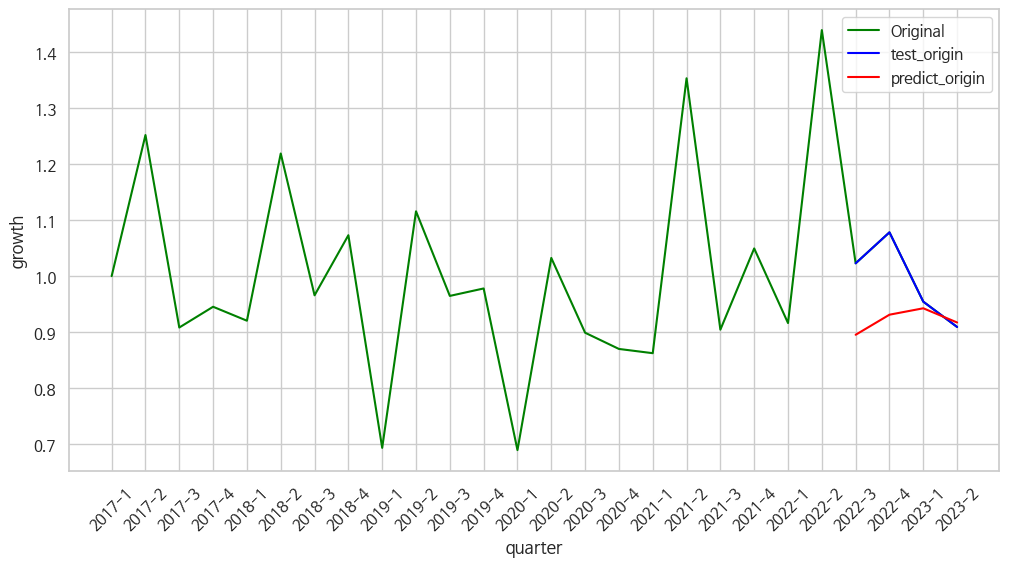

In [145]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [146]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.069593
std      0.078963
min     -0.008000
25%      0.006876
50%      0.069690
75%      0.132407
max      0.146991
dtype: float64

In [147]:
### 23년 3분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 52ms/step
[[0.2517847]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.8782155513763428 


### 시장성

In [148]:
### X / y 데이터 생성
X = sin_coffee[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_coffee.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   1.261288e+10  1.000000  0.421941
1   1.578852e+10  1.251778 -3.043478
2   1.434030e+10  0.908274 -1.769912
3   1.355599e+10  0.945307 -6.603774
4   1.247706e+10  0.920410 -4.433498
5   1.520741e+10  1.218829  5.581395
6   1.468648e+10  0.965745  2.714932
7   1.575843e+10  1.072989 -0.913242
8   1.092872e+10  0.693516 -0.458716
9   1.219267e+10  1.115654  6.837607
10  1.176192e+10  0.964671  1.271186
11  1.150270e+10  0.977961  4.435484
12  7.931017e+09  0.689492 -0.796813
13  8.188290e+09  1.032439  0.000000
14  7.361112e+09  0.898980  0.398406
15  6.404426e+09  0.870035  1.181102
16  5.523427e+09  0.862439 -0.395257
17  7.473483e+09  1.353052  3.435115
18  6.759494e+09  0.904464 -0.769231
19  7.093346e+09  1.049390  0.383142
20  6.499153e+09  0.916232  1.879699
21  9.352510e+09  1.439035  2.554745
22  9.566330e+09  1.022862  3.859649
23  1.031380e+10  1.078135 -0.354610
24  7.340207e+09  0.954428 -0.843485
25  7.056134e+09  0.909256 -1.060093
-

In [149]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [150]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.17698615 0.35346284 0.42854888]
 [0.14931253 0.2931966  0.4124339 ]]


In [151]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [152]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_21 (LSTM)              (None, 32)                12416     
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [153]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.5388
Epoch 1: val_loss improved from inf to 0.01058, saving model to stock_model.h5
1/1 [==============================] - 7s 7s/step - loss: 0.5388 - val_loss: 0.0106
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.5205
Epoch 2: val_loss improved from 0.01058 to 0.00930, saving model to stock_model.h5
1/1 [==============================] - 0s 88ms/step - loss: 0.5205 - val_loss: 0.0093
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5027
Epoch 3: val_loss improved from 0.00930 to 0.00821, saving model to stock_model.h5
1/1 [==============================] - 0s 84ms/step - loss: 0.5027 - val_loss: 0.0082
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.4856
Epoch 4: val_loss improved from 0.00821 to 0.00729, saving model to stock_model.h5
1/1 [==============================] - 0s 84ms/step - loss: 0.4856 - val_loss: 0.0073
Epoch 5/100
1/1 [=================

In [154]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 846ms/step
[[0.06396502]
 [0.07296289]
 [0.07572933]
 [0.06818413]]


In [155]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.246898,0.063965
2022-4,0.390708,0.072963
2023-1,0.153328,0.075729
2023-2,0.100971,0.068184


In [156]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 5].values       # 시장성이 sin_coffee의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.246898,0.063965,3.915651e+06,565369.5000,3.350282e+06
2022-4,0.390708,0.072963,6.549422e+06,730159.0625,5.819262e+06
2023-1,0.153328,0.075729,2.201984e+06,780824.5000,1.421159e+06
2023-2,0.100971,0.068184,1.243114e+06,642639.5625,6.004741e+05


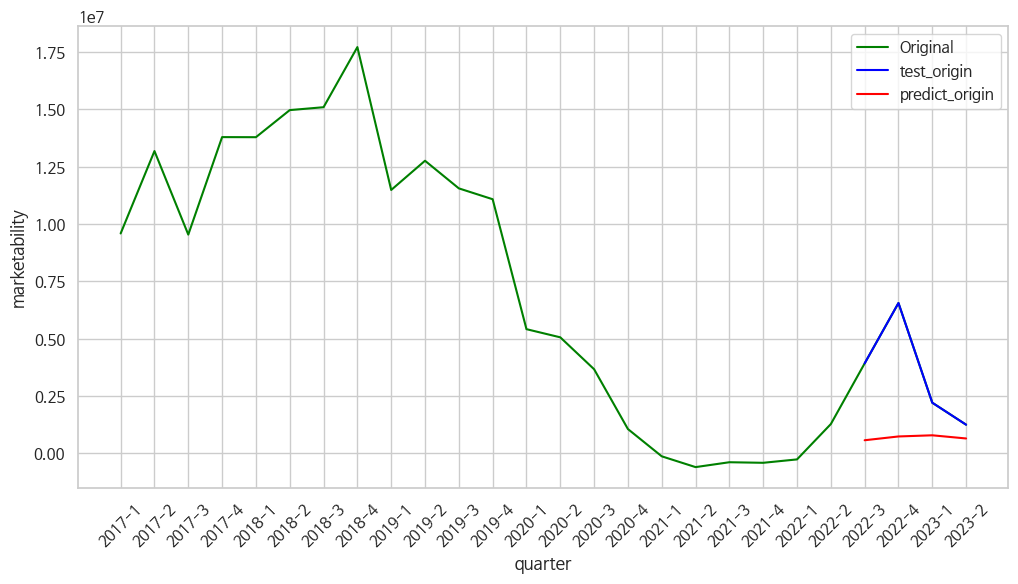

In [157]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [158]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     2.797794e+06
std      2.320765e+06
min      6.004741e+05
25%      1.215988e+06
50%      2.385721e+06
75%      3.967527e+06
max      5.819262e+06
dtype: float64

In [159]:
### 23년 3분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 28ms/step
[[0.06029402]]
--------------------------------------------------------------------------------
예측된 시장성  : 498137.84375 


### 순점포증감률

In [160]:
### X / y 데이터 생성
X = sin_coffee[['분기당_매출_금액', '성장성', '시장성']]
y = sin_coffee.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   1.261288e+10  1.000000  9.582203e+06
1   1.578852e+10  1.251778  1.317550e+07
2   1.434030e+10  0.908274  9.532443e+06
3   1.355599e+10  0.945307  1.378365e+07
4   1.247706e+10  0.920410  1.377974e+07
5   1.520741e+10  1.218829  1.496086e+07
6   1.468648e+10  0.965745  1.508716e+07
7   1.575843e+10  1.072989  1.770817e+07
8   1.092872e+10  0.693516  1.147899e+07
9   1.219267e+10  1.115654  1.275232e+07
10  1.176192e+10  0.964671  1.154829e+07
11  1.150270e+10  0.977961  1.107477e+07
12  7.931017e+09  0.689492  5.408660e+06
13  8.188290e+09  1.032439  5.052693e+06
14  7.361112e+09  0.898980  3.661522e+06
15  6.404426e+09  0.870035  1.053397e+06
16  5.523427e+09  0.862439 -1.355902e+05
17  7.473483e+09  1.353052 -6.061034e+05
18  6.759494e+09  0.904464 -3.937207e+05
19  7.093346e+09  1.049390 -4.183269e+05
20  6.499153e+09  0.916232 -2.705196e+05
21  9.352510e+09  1.439035  1.270680e+06
22  9.566330e+09  1.022862  3.915651e+06
23  1.031380e+10

In [161]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [162]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.17698615 0.35346284 0.15332778]
 [0.14931253 0.2931966  0.10097134]]


In [163]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [164]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_23 (LSTM)              (None, 32)                12416     
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [165]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3874
Epoch 1: val_loss improved from inf to 0.34860, saving model to stock_model.h5
1/1 [==============================] - 7s 7s/step - loss: 0.3874 - val_loss: 0.3486
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3721
Epoch 2: val_loss improved from 0.34860 to 0.33981, saving model to stock_model.h5
1/1 [==============================] - 0s 94ms/step - loss: 0.3721 - val_loss: 0.3398
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3573
Epoch 3: val_loss improved from 0.33981 to 0.33120, saving model to stock_model.h5
1/1 [==============================] - 0s 114ms/step - loss: 0.3573 - val_loss: 0.3312
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3429
Epoch 4: val_loss improved from 0.33120 to 0.32274, saving model to stock_model.h5
1/1 [==============================] - 0s 99ms/step - loss: 0.3429 - val_loss: 0.3227
Epoch 5/100
1/1 [================

In [166]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.30938745]
 [0.4031306 ]
 [0.42267096]
 [0.4171245 ]]


In [167]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.778449,0.309387
2022-4,0.464920,0.403131
2023-1,0.428549,0.422671
2023-2,0.412434,0.417125


In [168]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_coffee의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.778449,0.309387,3.859649,-2.445179,6.304828
2022-4,0.464920,0.403131,-0.354610,-1.185142,0.830532
2023-1,0.428549,0.422671,-0.843485,-0.922492,0.079007
2023-2,0.412434,0.417125,-1.060093,-0.997044,-0.063048


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


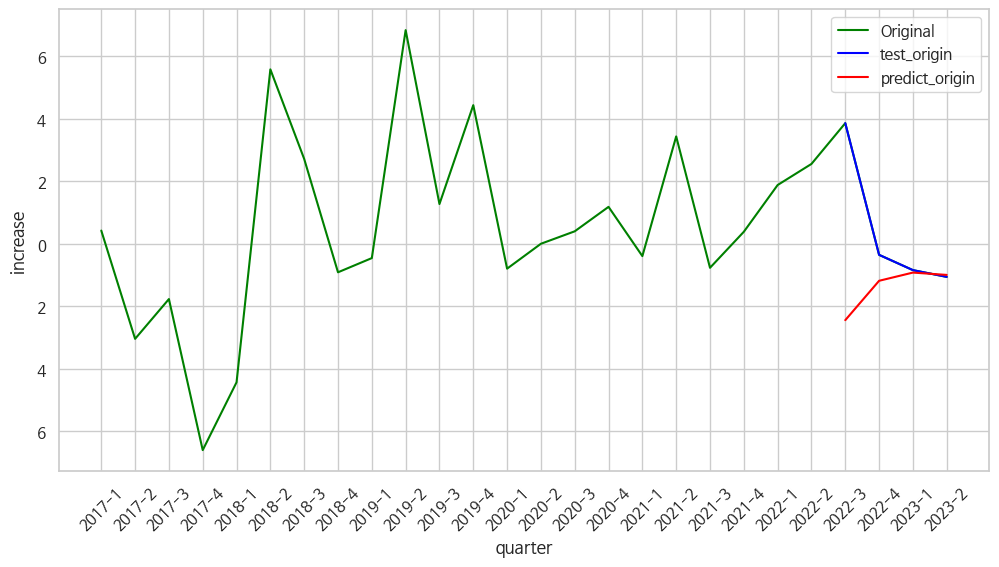

In [169]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [170]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     1.787830
std      3.036748
min     -0.063048
25%      0.043493
50%      0.454770
75%      2.199106
max      6.304828
dtype: float64

In [171]:
### 23년 3분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 37ms/step
[[0.3142149]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -2.3802919387817383 


### 추가

In [172]:
sin_coffee.loc[26] = ['2023-3', '커피-음료', sales, growth, increase, marketability]

<ipython-input-172-e03074095c4e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_coffee.loc[26] = ['2023-3', '커피-음료', sales, growth, increase, marketability]


In [173]:
sin_coffee

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,커피-음료,1.261288e+10,1.000000,0.421941,9.582203e+06
1,2017-2,커피-음료,1.578852e+10,1.251778,-3.043478,1.317550e+07
2,2017-3,커피-음료,1.434030e+10,0.908274,-1.769912,9.532443e+06
3,2017-4,커피-음료,1.355599e+10,0.945307,-6.603774,1.378365e+07
4,2018-1,커피-음료,1.247706e+10,0.920410,-4.433498,1.377974e+07
5,2018-2,커피-음료,1.520741e+10,1.218829,5.581395,1.496086e+07
6,2018-3,커피-음료,1.468648e+10,0.965745,2.714932,1.508716e+07
7,2018-4,커피-음료,1.575843e+10,1.072989,-0.913242,1.770817e+07
8,2019-1,커피-음료,1.092872e+10,0.693516,-0.458716,1.147899e+07
9,2019-2,커피-음료,1.219267e+10,1.115654,6.837607,1.275232e+07


## 23년 4분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본데이터에 추가

### 매출

In [174]:
### X / y 데이터 생성
X = sin_coffee[['성장성', '시장성', '순점포증감률']]
y = sin_coffee.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  9.582203e+06  0.421941
1   1.251778  1.317550e+07 -3.043478
2   0.908274  9.532443e+06 -1.769912
3   0.945307  1.378365e+07 -6.603774
4   0.920410  1.377974e+07 -4.433498
5   1.218829  1.496086e+07  5.581395
6   0.965745  1.508716e+07  2.714932
7   1.072989  1.770817e+07 -0.913242
8   0.693516  1.147899e+07 -0.458716
9   1.115654  1.275232e+07  6.837607
10  0.964671  1.154829e+07  1.271186
11  0.977961  1.107477e+07  4.435484
12  0.689492  5.408660e+06 -0.796813
13  1.032439  5.052693e+06  0.000000
14  0.898980  3.661522e+06  0.398406
15  0.870035  1.053397e+06  1.181102
16  0.862439 -1.355902e+05 -0.395257
17  1.353052 -6.061034e+05  3.435115
18  0.904464 -3.937207e+05 -0.769231
19  1.049390 -4.183269e+05  0.383142
20  0.916232 -2.705196e+05  1.879699
21  1.439035  1.270680e+06  2.554745
22  1.022862  3.915651e+06  3.859649
23  1.078135  6.549422e+06 -0.354610
24  0.954428  2.201984e+06 -0.843485
25  0.909256  1.243114e+06 -1.060093
2

In [175]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [176]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.2931966  0.10097134 0.4124339 ]
 [0.25178469 0.06029402 0.31421487]]


In [177]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [178]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_25 (LSTM)              (None, 32)                12416     
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [179]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.5532
Epoch 1: val_loss improved from inf to 0.04723, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.5532 - val_loss: 0.0472
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.5349
Epoch 2: val_loss improved from 0.04723 to 0.04395, saving model to stock_model.h5
1/1 [==============================] - 0s 98ms/step - loss: 0.5349 - val_loss: 0.0440
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5174
Epoch 3: val_loss improved from 0.04395 to 0.04092, saving model to stock_model.h5
1/1 [==============================] - 0s 99ms/step - loss: 0.5174 - val_loss: 0.0409
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5005
Epoch 4: val_loss improved from 0.04092 to 0.03808, saving model to stock_model.h5
1/1 [==============================] - 0s 118ms/step - loss: 0.5005 - val_loss: 0.0381
Epoch 5/100
1/1 [================

In [180]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 846ms/step
[[0.21859659]
 [0.207534  ]
 [0.19007418]
 [0.16761369]]


In [181]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.466666,0.218597
2023-1,0.176986,0.207534
2023-2,0.149313,0.190074
2023-3,0.144018,0.167614


In [182]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_coffee의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.466666,0.218597,1.031380e+10,7.767342e+09,2.546456e+09
2023-1,0.176986,0.207534,7.340207e+09,7.653783e+09,-3.135764e+08
2023-2,0.149313,0.190074,7.056134e+09,7.474556e+09,-4.184223e+08
2023-3,0.144018,0.167614,7.001784e+09,7.243997e+09,-2.422129e+08


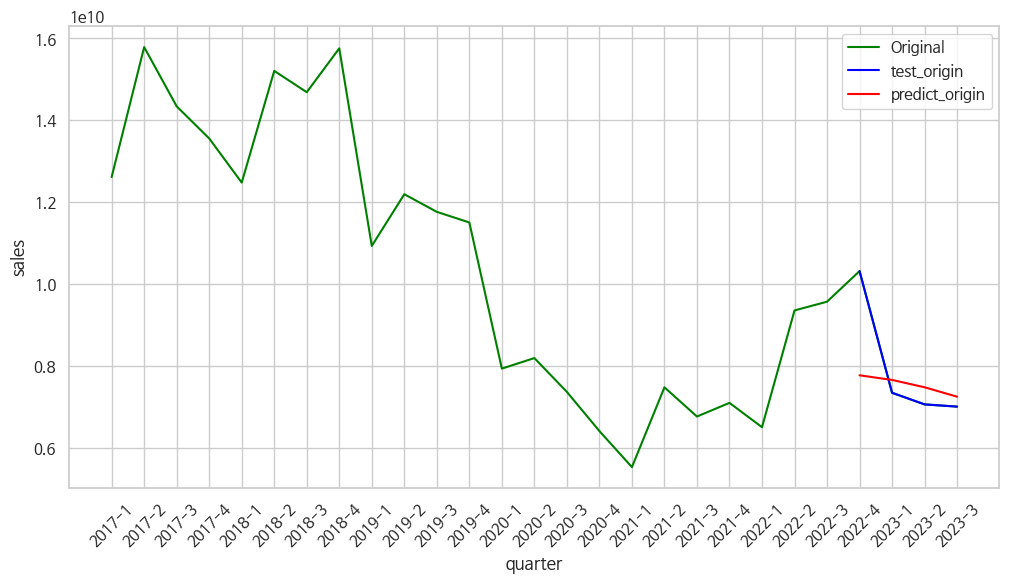

In [183]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [184]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     3.930611e+08
std      1.437420e+09
min     -4.184223e+08
25%     -3.397879e+08
50%     -2.778947e+08
75%      4.549544e+08
max      2.546456e+09
dtype: float64

In [185]:
### 23년 4분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 36ms/step
[[0.15723243]]
--------------------------------------------------------------------------------
예측된 매출  : 7137432576.0 


### 성장성

In [186]:
X = sin_coffee[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_coffee.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   1.261288e+10  9.582203e+06  0.421941
1   1.578852e+10  1.317550e+07 -3.043478
2   1.434030e+10  9.532443e+06 -1.769912
3   1.355599e+10  1.378365e+07 -6.603774
4   1.247706e+10  1.377974e+07 -4.433498
5   1.520741e+10  1.496086e+07  5.581395
6   1.468648e+10  1.508716e+07  2.714932
7   1.575843e+10  1.770817e+07 -0.913242
8   1.092872e+10  1.147899e+07 -0.458716
9   1.219267e+10  1.275232e+07  6.837607
10  1.176192e+10  1.154829e+07  1.271186
11  1.150270e+10  1.107477e+07  4.435484
12  7.931017e+09  5.408660e+06 -0.796813
13  8.188290e+09  5.052693e+06  0.000000
14  7.361112e+09  3.661522e+06  0.398406
15  6.404426e+09  1.053397e+06  1.181102
16  5.523427e+09 -1.355902e+05 -0.395257
17  7.473483e+09 -6.061034e+05  3.435115
18  6.759494e+09 -3.937207e+05 -0.769231
19  7.093346e+09 -4.183269e+05  0.383142
20  6.499153e+09 -2.705196e+05  1.879699
21  9.352510e+09  1.270680e+06  2.554745
22  9.566330e+09  3.915651e+06  3.859649
23  1.031380e+10

In [187]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [188]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.14931253 0.10097134 0.4124339 ]
 [0.1440179  0.06029402 0.31421487]]


In [189]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [190]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_27 (LSTM)              (None, 32)                12416     
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [191]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.1966
Epoch 1: val_loss improved from inf to 0.28678, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.1966 - val_loss: 0.2868
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.1855
Epoch 2: val_loss improved from 0.28678 to 0.27889, saving model to stock_model.h5
1/1 [==============================] - 0s 95ms/step - loss: 0.1855 - val_loss: 0.2789
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.1750
Epoch 3: val_loss improved from 0.27889 to 0.27125, saving model to stock_model.h5
1/1 [==============================] - 0s 97ms/step - loss: 0.1750 - val_loss: 0.2712
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1650
Epoch 4: val_loss improved from 0.27125 to 0.26385, saving model to stock_model.h5
1/1 [==============================] - 0s 130ms/step - loss: 0.1650 - val_loss: 0.2639
Epoch 5/100
1/1 [================

In [192]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 839ms/step
[[0.32239947]
 [0.33767346]
 [0.3038701 ]
 [0.2517847 ]]


In [193]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.518507,0.322399
2023-1,0.353463,0.337673
2023-2,0.293197,0.303870
2023-3,0.251785,0.251785


In [194]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 3].values       # 성장성이 sin_coffee의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.518507,0.322399,1.078135,0.931144,0.146991
2023-1,0.353463,0.337673,0.954428,0.942593,0.011835
2023-2,0.293197,0.303870,0.909256,0.917256,-0.008000
2023-3,0.251785,0.251785,0.878216,0.878216,0.000000


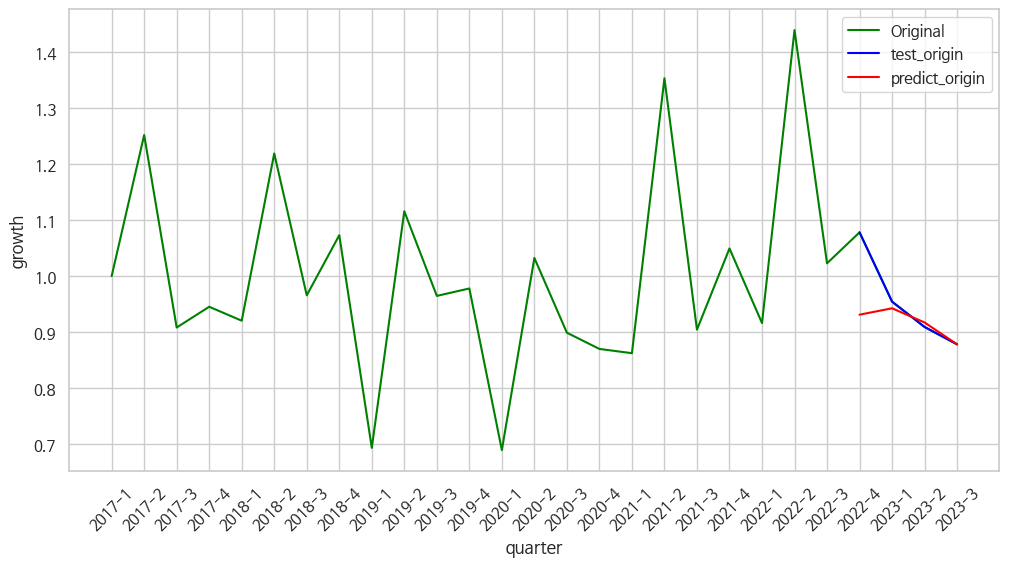

In [195]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [196]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.037706
std      0.073311
min     -0.008000
25%     -0.002000
50%      0.005917
75%      0.045624
max      0.146991
dtype: float64

In [197]:
### 23년 4분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 30ms/step
[[0.23775195]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.8676974177360535 


###시장성

In [198]:
### X / y 데이터 생성
X = sin_coffee[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_coffee.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   1.261288e+10  1.000000  0.421941
1   1.578852e+10  1.251778 -3.043478
2   1.434030e+10  0.908274 -1.769912
3   1.355599e+10  0.945307 -6.603774
4   1.247706e+10  0.920410 -4.433498
5   1.520741e+10  1.218829  5.581395
6   1.468648e+10  0.965745  2.714932
7   1.575843e+10  1.072989 -0.913242
8   1.092872e+10  0.693516 -0.458716
9   1.219267e+10  1.115654  6.837607
10  1.176192e+10  0.964671  1.271186
11  1.150270e+10  0.977961  4.435484
12  7.931017e+09  0.689492 -0.796813
13  8.188290e+09  1.032439  0.000000
14  7.361112e+09  0.898980  0.398406
15  6.404426e+09  0.870035  1.181102
16  5.523427e+09  0.862439 -0.395257
17  7.473483e+09  1.353052  3.435115
18  6.759494e+09  0.904464 -0.769231
19  7.093346e+09  1.049390  0.383142
20  6.499153e+09  0.916232  1.879699
21  9.352510e+09  1.439035  2.554745
22  9.566330e+09  1.022862  3.859649
23  1.031380e+10  1.078135 -0.354610
24  7.340207e+09  0.954428 -0.843485
25  7.056134e+09  0.909256 -1.060093
2

In [199]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [200]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.14931253 0.2931966  0.4124339 ]
 [0.1440179  0.25178469 0.31421487]]


In [201]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [202]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_29 (LSTM)              (None, 32)                12416     
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [203]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.5388
Epoch 1: val_loss improved from inf to 0.01735, saving model to stock_model.h5
1/1 [==============================] - 8s 8s/step - loss: 0.5388 - val_loss: 0.0174
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.5205
Epoch 2: val_loss improved from 0.01735 to 0.01560, saving model to stock_model.h5
1/1 [==============================] - 0s 97ms/step - loss: 0.5205 - val_loss: 0.0156
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5027
Epoch 3: val_loss improved from 0.01560 to 0.01403, saving model to stock_model.h5
1/1 [==============================] - 0s 96ms/step - loss: 0.5027 - val_loss: 0.0140
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.4856
Epoch 4: val_loss improved from 0.01403 to 0.01266, saving model to stock_model.h5
1/1 [==============================] - 0s 103ms/step - loss: 0.4856 - val_loss: 0.0127
Epoch 5/100
1/1 [================

In [204]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 887ms/step
[[0.09942972]
 [0.10038928]
 [0.09016413]
 [0.07891282]]


In [205]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.390708,0.099430
2023-1,0.153328,0.100389
2023-2,0.100971,0.090164
2023-3,0.060294,0.078913


In [206]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 5].values       # 시장성이 sin_coffee의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.390708,0.099430,6.549422e+06,1214879.875,5.334542e+06
2023-1,0.153328,0.100389,2.201984e+06,1232453.500,9.695302e+05
2023-2,0.100971,0.090164,1.243114e+06,1045187.375,1.979262e+05
2023-3,0.060294,0.078913,4.981378e+05,839127.875,-3.409900e+05


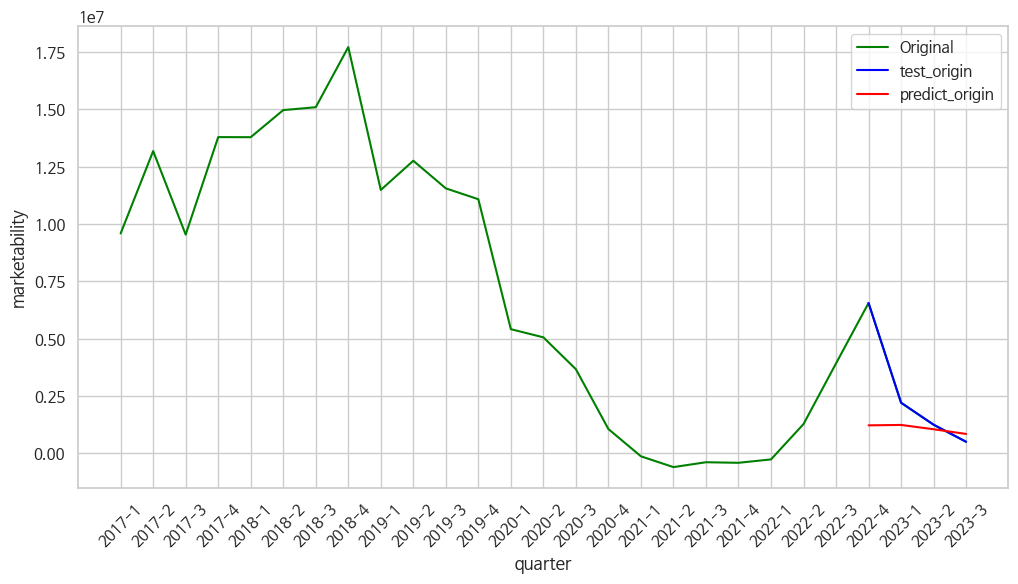

In [207]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [208]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     1.540252e+06
std      2.586070e+06
min     -3.409900e+05
25%      6.319718e+04
50%      5.837282e+05
75%      2.060783e+06
max      5.334542e+06
dtype: float64

In [209]:
### 23년 4분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 32ms/step
[[0.0764306]]
--------------------------------------------------------------------------------
예측된 시장성  : 793667.75 


### 순점포증감률

In [210]:
### X / y 데이터 생성
X = sin_coffee[['분기당_매출_금액', '성장성', '시장성']]
y = sin_coffee.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   1.261288e+10  1.000000  9.582203e+06
1   1.578852e+10  1.251778  1.317550e+07
2   1.434030e+10  0.908274  9.532443e+06
3   1.355599e+10  0.945307  1.378365e+07
4   1.247706e+10  0.920410  1.377974e+07
5   1.520741e+10  1.218829  1.496086e+07
6   1.468648e+10  0.965745  1.508716e+07
7   1.575843e+10  1.072989  1.770817e+07
8   1.092872e+10  0.693516  1.147899e+07
9   1.219267e+10  1.115654  1.275232e+07
10  1.176192e+10  0.964671  1.154829e+07
11  1.150270e+10  0.977961  1.107477e+07
12  7.931017e+09  0.689492  5.408660e+06
13  8.188290e+09  1.032439  5.052693e+06
14  7.361112e+09  0.898980  3.661522e+06
15  6.404426e+09  0.870035  1.053397e+06
16  5.523427e+09  0.862439 -1.355902e+05
17  7.473483e+09  1.353052 -6.061034e+05
18  6.759494e+09  0.904464 -3.937207e+05
19  7.093346e+09  1.049390 -4.183269e+05
20  6.499153e+09  0.916232 -2.705196e+05
21  9.352510e+09  1.439035  1.270680e+06
22  9.566330e+09  1.022862  3.915651e+06
23  1.031380e+10

In [211]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [212]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.14931253 0.2931966  0.10097134]
 [0.1440179  0.25178469 0.06029402]]


In [213]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [214]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_31 (LSTM)              (None, 32)                12416     
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [215]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3874
Epoch 1: val_loss improved from inf to 0.38034, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.3874 - val_loss: 0.3803
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3721
Epoch 2: val_loss improved from 0.38034 to 0.37109, saving model to stock_model.h5
1/1 [==============================] - 0s 132ms/step - loss: 0.3721 - val_loss: 0.3711
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3573
Epoch 3: val_loss improved from 0.37109 to 0.36203, saving model to stock_model.h5
1/1 [==============================] - 0s 130ms/step - loss: 0.3573 - val_loss: 0.3620
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3429
Epoch 4: val_loss improved from 0.36203 to 0.35311, saving model to stock_model.h5
1/1 [==============================] - 0s 151ms/step - loss: 0.3429 - val_loss: 0.3531
Epoch 5/100
1/1 [==============

In [216]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 839ms/step
[[0.4031306 ]
 [0.42267096]
 [0.4171245 ]
 [0.3142149 ]]


In [217]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.464920,0.403131
2023-1,0.428549,0.422671
2023-2,0.412434,0.417125
2023-3,0.314215,0.314215


In [218]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_coffee의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.464920,0.403131,-0.354610,-1.185142,0.830532
2023-1,0.428549,0.422671,-0.843485,-0.922492,0.079007
2023-2,0.412434,0.417125,-1.060093,-0.997044,-0.063048
2023-3,0.314215,0.314215,-2.380292,-2.380292,0.000000


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


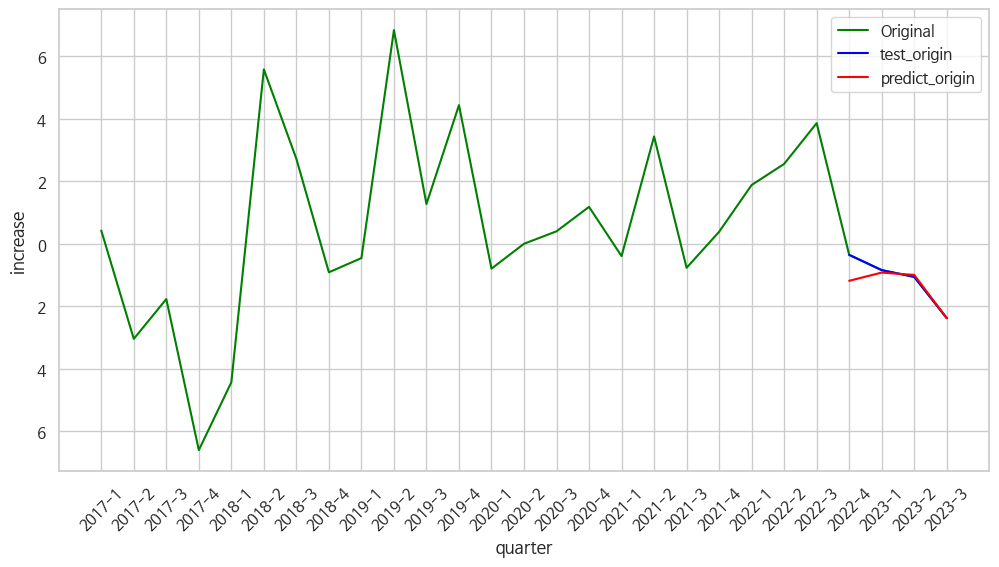

In [219]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [220]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.211623
std      0.416679
min     -0.063048
25%     -0.015762
50%      0.039504
75%      0.266888
max      0.830532
dtype: float64

In [221]:
### 23년 2분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 27ms/step
[[0.29204798]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -2.678245782852173 


### 추가

In [222]:
sin_coffee.loc[27] = ['2023-4', '커피-음료', sales, growth, increase, marketability]

<ipython-input-222-49964b0d57d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_coffee.loc[27] = ['2023-4', '커피-음료', sales, growth, increase, marketability]


In [223]:
final_sin_coffee = sin_coffee
final_sin_coffee

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,커피-음료,1.261288e+10,1.000000,0.421941,9.582203e+06
1,2017-2,커피-음료,1.578852e+10,1.251778,-3.043478,1.317550e+07
2,2017-3,커피-음료,1.434030e+10,0.908274,-1.769912,9.532443e+06
3,2017-4,커피-음료,1.355599e+10,0.945307,-6.603774,1.378365e+07
4,2018-1,커피-음료,1.247706e+10,0.920410,-4.433498,1.377974e+07
5,2018-2,커피-음료,1.520741e+10,1.218829,5.581395,1.496086e+07
6,2018-3,커피-음료,1.468648e+10,0.965745,2.714932,1.508716e+07
7,2018-4,커피-음료,1.575843e+10,1.072989,-0.913242,1.770817e+07
8,2019-1,커피-음료,1.092872e+10,0.693516,-0.458716,1.147899e+07
9,2019-2,커피-음료,1.219267e+10,1.115654,6.837607,1.275232e+07


## 최종결과

In [224]:
### X / y 데이터 생성
X = sin_coffee[['성장성', '시장성', '순점포증감률']]
y = sin_coffee.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  9.582203e+06  0.421941
1   1.251778  1.317550e+07 -3.043478
2   0.908274  9.532443e+06 -1.769912
3   0.945307  1.378365e+07 -6.603774
4   0.920410  1.377974e+07 -4.433498
5   1.218829  1.496086e+07  5.581395
6   0.965745  1.508716e+07  2.714932
7   1.072989  1.770817e+07 -0.913242
8   0.693516  1.147899e+07 -0.458716
9   1.115654  1.275232e+07  6.837607
10  0.964671  1.154829e+07  1.271186
11  0.977961  1.107477e+07  4.435484
12  0.689492  5.408660e+06 -0.796813
13  1.032439  5.052693e+06  0.000000
14  0.898980  3.661522e+06  0.398406
15  0.870035  1.053397e+06  1.181102
16  0.862439 -1.355902e+05 -0.395257
17  1.353052 -6.061034e+05  3.435115
18  0.904464 -3.937207e+05 -0.769231
19  1.049390 -4.183269e+05  0.383142
20  0.916232 -2.705196e+05  1.879699
21  1.439035  1.270680e+06  2.554745
22  1.022862  3.915651e+06  3.859649
23  1.078135  6.549422e+06 -0.354610
24  0.954428  2.201984e+06 -0.843485
25  0.909256  1.243114e+06 -1.060093
2

In [225]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (28, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (28, 1)


In [226]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (26, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (26, 1)
[[0.25178469 0.06029402 0.31421487]
 [0.23775197 0.0764306  0.29204797]]


In [227]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (22, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (22, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [228]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_33 (LSTM)              (None, 32)                12416     
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [229]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.5136
Epoch 1: val_loss improved from inf to 0.06823, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.5136 - val_loss: 0.0682
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.4965
Epoch 2: val_loss improved from 0.06823 to 0.06414, saving model to stock_model.h5
1/1 [==============================] - 0s 126ms/step - loss: 0.4965 - val_loss: 0.0641
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.4801
Epoch 3: val_loss improved from 0.06414 to 0.06031, saving model to stock_model.h5
1/1 [==============================] - 0s 107ms/step - loss: 0.4801 - val_loss: 0.0603
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.4643
Epoch 4: val_loss improved from 0.06031 to 0.05670, saving model to stock_model.h5
1/1 [==============================] - 0s 136ms/step - loss: 0.4643 - val_loss: 0.0567
Epoch 5/100
1/1 [==============

In [230]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 865ms/step
[[0.2409413 ]
 [0.22035815]
 [0.19323021]
 [0.18087275]]


In [231]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_coffee.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2023-1,0.176986,0.240941
2023-2,0.149313,0.220358
2023-3,0.144018,0.193230
2023-4,0.157232,0.180873


In [232]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_coffee.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_coffee의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2023-1,0.176986,0.240941,7.340207e+09,7.996712e+09,-656505856.0
2023-2,0.149313,0.220358,7.056134e+09,7.785424e+09,-729290240.0
2023-3,0.144018,0.193230,7.001784e+09,7.506953e+09,-505168896.0
2023-4,0.157232,0.180873,7.137433e+09,7.380103e+09,-242670592.0


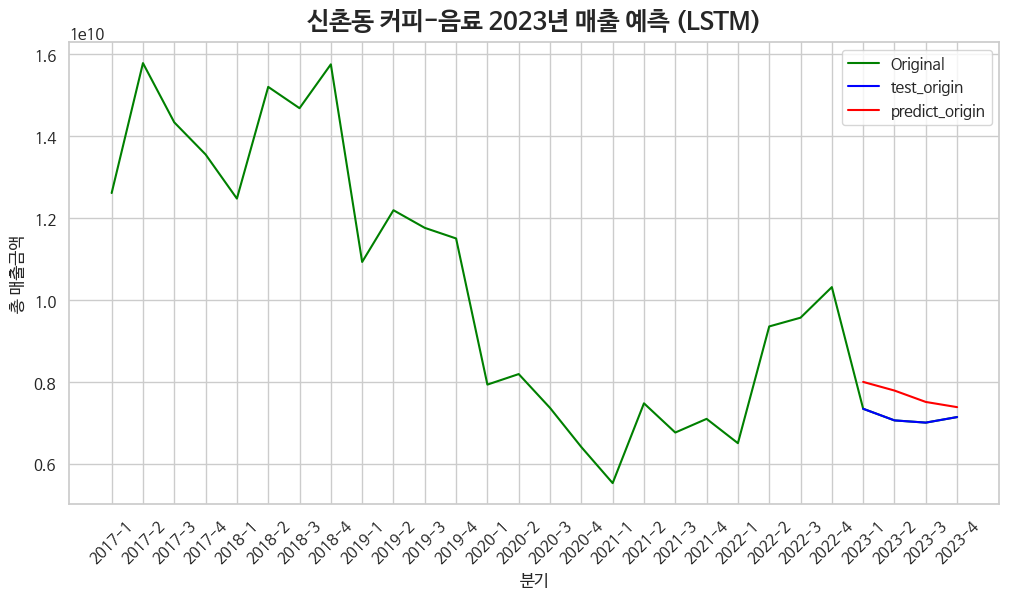

In [233]:
df_test = df_test.reset_index()

### 결과 시각화

plt.figure(figsize=(12, 6))
plt.plot(sin_coffee['분기'], sin_coffee['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.title('신촌동 커피-음료 2023년 매출 예측 (LSTM)', fontsize = 18, fontweight='bold', pad =10)
plt.xticks(rotation=45)
plt.xlabel('분기')
plt.ylabel('총 매출금액')
plt.legend()
plt.show()